In [22]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set()

# Exercise 1: Generating random numbers

<h3> (1) Linear Congruential Generator </h3>

We define a linear congruentical generator algorithm for producing pseudo-random numbers as well as statistical tests and run tests for evaluating its performance.

In [9]:
def LCG(a = 5, c = 1, M = 16, x0 = 3, n = 10000):
    """ Linear congruential generator for generating psuedo random numbers"""
    x = np.zeros(n)
    x[0] = x0

    for i in range(1, n):
        x[i] = int((a * x[i - 1] + c ) % M)

    return x.astype(int)

def test_chi_square(U):
    """ Compute the p-value of the null-hypothesis that the pseudo-random
        numbers come from a uniform distribution. """
    n = U.shape[0]
    
    k = int(n / 500)

    n_observed = np.histogram(U, bins=k, range=(0,1))[0]
    
    # Compute test statistics
    n_expected = n / k # Choose n_expected >= 5
    Z = ((n_observed - n_expected) ** 2 / n_expected).sum() # test statistic
    
    p = 1 - stats.chi2.cdf(Z, df = k - 1)

    return Z, p # (test statistic, p-value)

def test_ks(U):
    """ Kolmogorov-Smirnov test """
    n = U.shape[0]

    Fxn = U.copy()
    Fxn.sort()

    # Fxn = ECDF(U).x[1:] # Empirical distribution
    
    Fx = np.linspace(0, 1, n) # Hypothesised uniform distribution
    
    Dn = np.abs(Fxn - Fx).max() # Test statistic
    Dn_adjusted = (np.sqrt(n) + .12 + .11 / np.sqrt(n)) * Dn

    # p_value
    p = 1 - stats.kstwobign.cdf(Dn_adjusted)

    # p = stats.kstwo.sf(Dn_adjusted, 1)

    return Dn_adjusted, p

def test_above_below(U):
    n = U.shape[0]

    Ra = 0
    Rb = 0

    mid = np.median(U)

    n1 = U[U > mid].shape[0]
    n2 = U[U < mid].shape[0]

    mean_ = 2 * n1 * n2 / (n1 +  n2)
    var_ = (2 * n1 * n2) * (2 * n1 * n2 - n1 - n1) / ((n1 + n2) ** 2 * (n1 + n2 - 1))

    diffs = U - mid

    for i in range(0, n):
        # handle first value separately
        if i == 0:
            cur = np.sign(diffs[i])
            if cur > 0:
                Ra += 1
            elif cur < 0:
                Rb += 1 

            continue

        cur = np.sign(diffs[i])
        prev = np.sign(diffs[i - 1])
        if cur != prev:
            if cur > 0:
                Ra += 1
            elif cur < 0:
                Rb += 1 

    Z = Ra + Rb # Test statistic
    p = 2*(1 - stats.norm.cdf(np.abs(Z-mean_), loc = 0, scale = np.sqrt(var_))) # p-value

    return Z, p

def test_up_down_knuth(U):
    """ Run test by Knuth """
    n = U.shape[0]
    R = np.zeros(6) # runs

    counter = 1

    for i in range(1, n):
        if U[i] >= U[i-1]: # Should it be GOQ?
            counter += 1
        else:
            if counter > 5:
                R[5] += 1
            else:
                R[counter - 1] += 1
            counter = 1
    
    A = np.array([[4529.4, 9044.9, 13568, 18091, 22615, 27892],
                  [9044.9, 18097, 27139, 36187, 45234, 55789],
                  [13568, 27139, 40721, 54281, 67852, 83685],
                  [18091, 36187, 54281, 72414, 90470, 111580],
                  [22615, 45234, 67852, 90470, 113262, 139476],
                  [27892, 55789, 83685, 111580, 139476, 172860]])
    
    B = np.atleast_2d([1/6, 5/24, 11/120, 19/720, 29/5040, 1/840]).T

    R = np.atleast_2d(R).T

    Z = (1/(n - 6) * (R - n*B).T @ A @ (R - n * B))[0, 0]

    p = 1 - stats.chi2.cdf(Z, df = 6)

    return Z, p

def test_up_down_rubenstein(U):
    """ Run test described in Rubenstein 1981 """
    n = U.shape[0]
    
    runs = []

    cur_run = '<' if U[0] <= U[1] else '>'

    counter = 1

    for i in range(1, n - 1):
        if cur_run == '<':
            if U[i] <= U[i + 1]:
                counter += 1
            else:
                cur_run = '>'
                runs.append(counter)
                counter = 1
        else:
            if U[i] >= U[i + 1]:
                counter += 1
            else:
                cur_run = '<'
                runs.append(counter)
                counter = 1

    runs.append(counter)

    X = len(runs)

    Z = (X - (2 *n - 1) / 3) / np.sqrt((16* n - 29) / 90)

    p = 2 * (1 - stats.norm.cdf(np.abs(Z)))

    return Z, p

def test_correlation(U, h = 1):
    n = U.shape[0]

    sum_ = 0

    for i in range(n - h):
        sum_ += U[i] * U[i + h]

    ch = 1 / (n - h) * sum_

    Z = ch # test statistic

    p = 2 * (1 - stats.norm.cdf(np.abs(Z), loc = 0.25, scale = 7 / (144 * n)))

    return Z, p

def conduct_tests(U):
    Z, p = test_chi_square(U)
    print(f'Chi-square test: test-statistic: {Z:.4f}, p-value: {p:.4f}')
    Z, p = test_ks(U)
    print(f'Kolmogorov-Smirnov test: test-statistic: {Z:.4f}, p-value: {p:.4f}')
    Z, p = test_above_below(U)
    print(f'Run test I (Above-Below): test-statistic: {Z:.4f}, p-value: {p:.4f}')
    Z, p = test_up_down_knuth(U)
    print(f'Run test II (Up-Down Knuth): test-statistic: {Z:.4f}, p-value: {p:.4f}')
    Z, p = test_up_down_rubenstein(U)
    print(f'Run test III (Up-Down Rubenstein): test-statistic: {Z:.4f}, p-value: {p:.4f}')
    Z, p = test_correlation(U, h = 2)
    print(f'Correlation test: test-statistic: {Z:.4f}, p-value: {p:.4f}')

<h3>(1a) Generate 10 000 pseudo-random numbers</h3>

A sample of 10000 pseudo-random numbers are generated using the linear congruential generator using the same parameter values as in the slideshow.

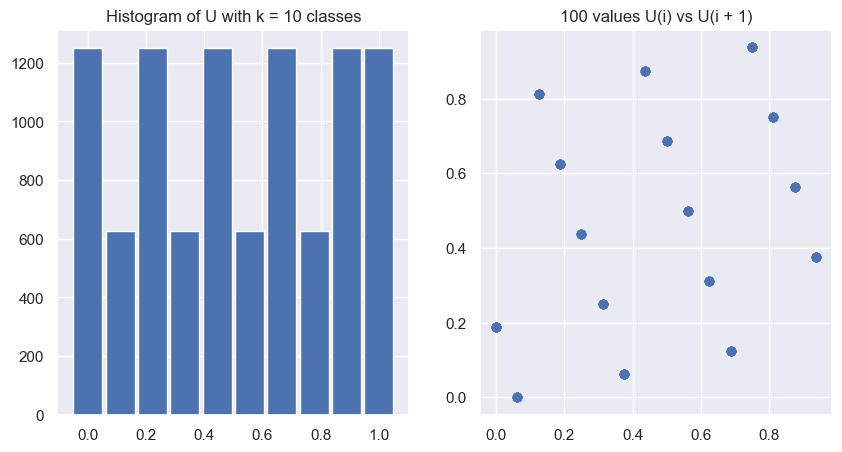

In [7]:
# Parameter values
n = 10000
x0 = 3
M = 16
a = 5
c = 1

X = LCG(a = a, c = c, M = M, x0 = x0, n = n)
U = X / M

k = 10 # Number of classes

heights = np.histogram(U, bins = k)[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(np.linspace(0, 1, k), height = heights, width = .1, )
ax[0].set_title(f'Histogram of U with k = {k} classes')
ax[1].scatter(U[:100][1:], U[:100][:-1])
ax[1].set_title(f'100 values U(i) vs U(i + 1)')
plt.show()

We see from the plots above that the sample of 10000 pseudo random numbers on the surface does not look likely to be uniform and independently distributed. There are high and low peaks in the histogram, and the scatter plot show that there seem to be a pattern between the samples, indicating that the values are highly correlated. Statistical tests can help verify these observations.

<h3>(b) Evaluate quality of generators </h3>

In [10]:
conduct_tests(U)

Chi-square test: test-statistic: 2500.0000, p-value: 0.0000
Kolmogorov-Smirnov test: test-statistic: 6.2576, p-value: 0.0000
Run test I (Above-Below): test-statistic: 3750.0000, p-value: 0.0000
Run test II (Up-Down Knuth): test-statistic: 1121.7928, p-value: 0.0000
Run test III (Up-Down Rubenstein): test-statistic: -9.8751, p-value: 0.0000
Correlation test: test-statistic: 0.2168, p-value: 2.0000


We see from these result that using Chi-square, Kolmogorov-Smirnov and run tests we are able to reject the null hypothesis that the pseudo-random numbers are uniformly distributed using significance level $\alpha = 0.05$, confirming the suspicion from the visual tests of histogram and correlations. We also accept that the U[i] is correlated with U[i + 1].

<h3>(c) Repeat experiment with different parameter values of LCG</h3>

We have already reported bad values of $(a, c, M, x_0) = (5, 1, 16, 3)$ in the previous task. To create a LCG that work well we have experimented with different parameter values and searched the internet for inspiration. We have settled on the following values:

$M = 2^{48}$,
$a = 25214903917$,
$c = 11$,
$x_0 = 3$

We will generate a sample of 10000 pseudo-random numbers using these values and run the same tests as in the previous task

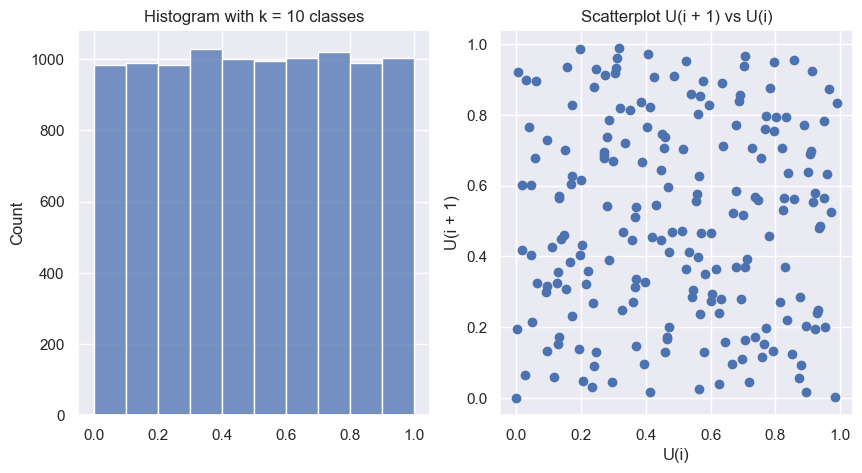

In [11]:
# a) Generate 10 000 numbers and plot them in histogram
n = 10000
k = 10
M = 2 ** 48
a = 25214903917
c = 11
x0 = 3

# Generating and plotting
nums = LCG(a, c, M, x0, n)
U = nums / M
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sbn.histplot(U, bins=k, ax=ax[0])
ax[0].set_title(f"Histogram with k = {k} classes")
ax[1].scatter(U[:200][:-1], U[:200][1:])
ax[1].set_ylabel("U(i + 1)")
ax[1].set_xlabel("U(i)")
ax[1].set_title(f"Scatterplot U(i + 1) vs U(i)")

plt.show()


In [12]:
conduct_tests(U)

Chi-square test: test-statistic: 9.5160, p-value: 0.9639
Kolmogorov-Smirnov test: test-statistic: 0.5818, p-value: 0.8875
Run test I (Above-Below): test-statistic: 5023.0000, p-value: 0.6455
Run test II (Up-Down Knuth): test-statistic: 0.9072, p-value: 0.9889
Run test III (Up-Down Rubenstein): test-statistic: 0.6562, p-value: 0.5117
Correlation test: test-statistic: 0.2509, p-value: 0.0000


For these parameters of the LCG we get from the plots that they are seemingly uniformly distributed. The vertical bars of the histogram are closely alligned but not exactly the same, indicating that there is some (pseudo) random variation in the frequency of the sample. The plot to the right show no real pattern between one sample and the next in the sequence, meaning that they are not correlated with each other. 

As for the statistical tests, none return a p-value larger than $\alpha = 0.05$, meaning that we accept the null-hypothesis of the sample coming from a uniform distribution. We also reject that the random variables are correlated with the next in the sequence.

<h3>(2) Apply a system RNG and perform the same tests</h3>

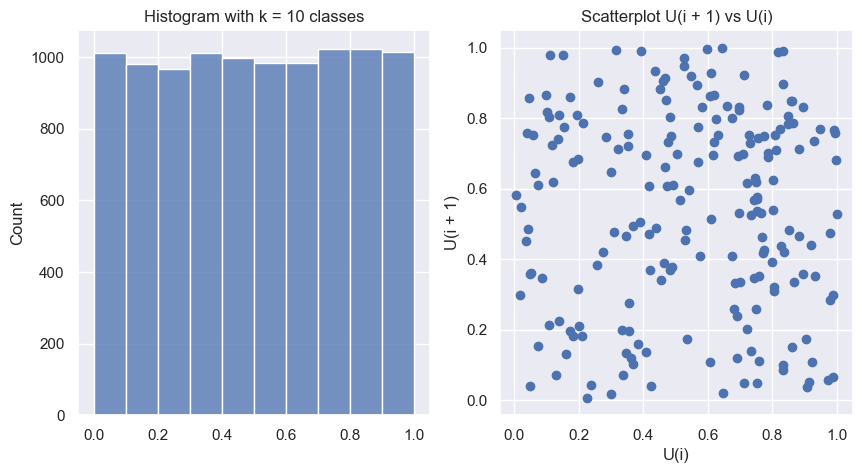

In [13]:
U = np.random.uniform(0, 1, size = 10000)

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sbn.histplot(U, bins=k, ax=ax[0])
ax[0].set_title(f"Histogram with k = {k} classes")
ax[1].scatter(U[:200][:-1], U[:200][1:])
ax[1].set_ylabel("U(i + 1)")
ax[1].set_xlabel("U(i)")
ax[1].set_title(f"Scatterplot U(i + 1) vs U(i)")

plt.show()

In [14]:
conduct_tests(U)

Chi-square test: test-statistic: 13.3520, p-value: 0.8201
Kolmogorov-Smirnov test: test-statistic: 0.7568, p-value: 0.6157
Run test I (Above-Below): test-statistic: 5019.0000, p-value: 0.7039
Run test II (Up-Down Knuth): test-statistic: 5.4829, p-value: 0.4835
Run test III (Up-Down Rubenstein): test-statistic: 0.8460, p-value: 0.3976
Correlation test: test-statistic: 0.2550, p-value: 0.0000


We get the similar results in the previous task. Here, however the bars of the histogram are less alligned.

<h3>(3) Multiple sample test</h3>

The problem with measuring the performance of our RNG using only a single sample is that we may come to the wrong conclusions due to random variations in the sample generation. It would be better if we performed more experiments and averaged the results, to get a better idea on how the generator performs consistently. For this purpose we choose to sample ten million numbers with our LCG and peform the chisquare test on intervals of size 10000. Here we would expect the p-values to be uniformly distributed. 

We perform the experiments using paramter values from task (1c) and compare with the same experiment using a built-in RNG.

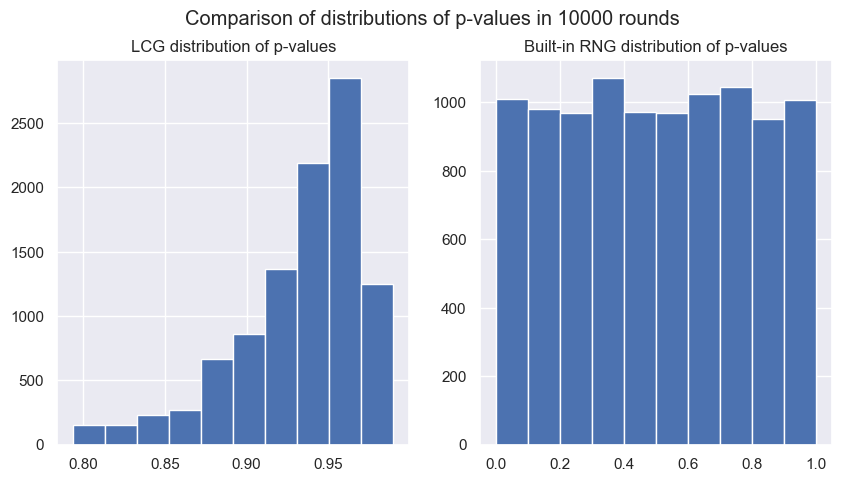

In [ ]:
n_sample = int(1e8)
n = 10000
U_lcg = LCG(a = a, c = c, M = M, x0 = x0, n = n_sample) / M
U_system = np.random.uniform(0, 1, size = n_sample)

rounds = int(n_sample / n)

p_vals_lcg = np.zeros(rounds)
p_vals_system = np.zeros(rounds)

for r in range(rounds):
    u = U_lcg[r*n:(r+1)*n]
    _, p = test_chi_square(u)
    p_vals_lcg[r] = p

    u = U_system[r*n:(r+1)*n]
    _, p = test_chi_square(u)
    p_vals_system[r] = p

n_bins = 10

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(p_vals_lcg, bins = n_bins)
ax[0].set_title('LCG distribution of p-values')
ax[1].hist(p_vals_system, bins = n_bins)
ax[1].set_title('Built-in RNG distribution of p-values')
fig.suptitle(f'Comparison of distributions of p-values in {rounds} rounds')

plt.show()

We see from these results that the p-values of the built-in random number generator are uniformly distributed as would be expected. The p-values of our own implementation using LCG however is not, with values in the range 0.8 - 1.0 only. This indicates that our implementation is not 'random' enough, as we would expect lower p-values for some runs as well.

# Exercise 2: Discrete random variables

<h3> (1) Geometric distributions

For sampling values from the geometric distribution, a function is defined. The function is used to sample 10000 values, for three different values of p. The histogrammes are compared below.

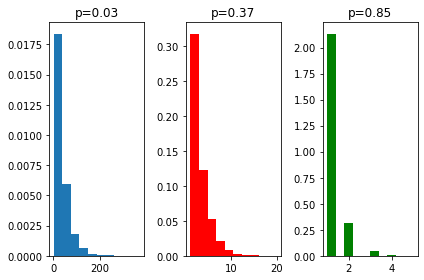

In [ ]:
def geom(p,N):
    U = np.random.random(N)
    return np.floor(np.log(U)/np.log(1-p)) + 1
p1,p2,p3=0.03,0.37,0.85
gm1,gm2,gm3 = geom(p1,10000),geom(p2,10000),geom(p3,10000)

#Histograms
plt.figure()
plt.subplot(1, 3, 1)
plt.hist(gm1,density=True)
plt.title("p=0.03")

plt.subplot(1, 3, 2)
plt.hist(gm2,density=True,color='red')
plt.title("p=0.37")
plt.subplot(1, 3, 3)
plt.hist(gm3,density=True,color='green')
plt.title("p=0.85")
plt.tight_layout()


The histogrammes clearly show geometric distributions with different shapes.

<h3> (2) 6-point distribution

We can simulate the given 6-point distribution using the three methods; ’the crude method',
the 'rejection method' and the 'alias method'.
In all the methods, uniformly distributed random numbers are generated and used to sample
from the desired distribution. The implementations are made in a way such that a list of uniform random numbers are already available (for testing purposes) - this is true except for when the rejection method has rejected a value.

In [ ]:
n = 1000000
np.random.seed(12346) #set random seed
randoms = np.random.uniform(size=(n,2))

<h4> (2a) The Crude Method

The direct method makes use of the CDF, of the given distribution - note that the function is discrete. A uniform random number is generated. The random number will land in one of the probability intervals (on the CDF) for each outcome. When the random number lands within this interval, the corresponding outcome is chosen. 

In [ ]:
p = np.array([7/48,5/48,1/8,1/16,1/4,5/16])
pa = np.cumsum(p)

def ncrude(nn):
    ss = np.zeros(nn)
    #U = np.random.uniform(size=nn)
    Uc = randoms[0:nn,0].copy()
    for j in range(nn):
        for i in range(6):
            if Uc[j] < pa[i]:
                ss[j] = i+1
                break
    return ss

<h4> (2b) The Rejection Method

The rejection method works differently. It generates two uniform random numbers, whereof one of them is used to generate a potential number from the distribution (1-6), while the other is used to simulate the probability of that outcome being accepted/rejected. 

In [ ]:
k = 6
q = 1/k
c = max(p)/q
def nrejection(nn):
    ss = np.zeros(nn)
    Ur = randoms[0:nn,:].copy()#np.random.uniform(size=[nn,2])
    #U1 = np.random.uniform(size=nn)
    #U2 = np.random.random(nn)
    for j in range(nn):
        while(ss[j]==0):
            Y = int(k*Ur[j,0])+1
            if Ur[j,1] <= p[Y-1]/(c*q):
                ss[j] = Y
                break
            else:
                Ur[j,0],Ur[j,1] = np.random.uniform(size=2)
    return ss

<h4> The Alias Method

For the alias method, a set of auxillary tables has to be set up. Like in the rejection method, two uniform random numbers are generated. However, unlike the rejection method, a set of numbers cannot be fully rejected - but are used for choosing an outcome. The method is implemented below.

In [ ]:
#Setup for alias using pseudo-code from slides
L=np.ones(k)*range(k)
F=k*p
G = np.where(F>=1)[0]
S = np.where(F<=1)[0]
while np.size(S)>0:
    i = G[0]
    j = S[0]
    L[j] = i+1
    F[i] = F[i] - (1 - F[j])
    
    if F[i] < 1-0.000001:
        G = np.delete(G,0)
        S = np.append(S,i)
    S = np.delete(S,0)

#The alias method
def nalias(nn):
    ss = np.zeros(nn)
    UA = randoms[0:nn,:].copy()
    for j in range(nn):
        I = (np.floor(k*UA[j,0]) + 1).astype(int)
        if UA[j,1] <= F[I-1]:
            ss[j] = I
        else:
            ss[j] = L[I-1]
    return ss

<h3> (3) Comparison of the methods

The three methods' precision and efficiency can be compared. Histograms and runtimes are examined.

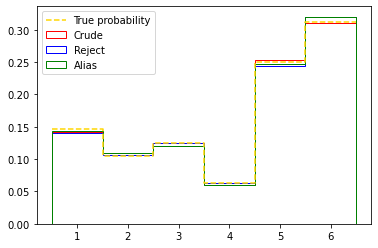

In [ ]:
N_samples = 10000
p = np.array([7/48,5/48,1/8,1/16,1/4,5/16])
pp = p.tolist()
pp.append(p[-1])
plt.hist(ncrude(N_samples),bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5],density=1, rwidth=1,edgecolor='red',color='red',alpha=1,histtype='step',label="Crude")
plt.hist(nrejection(N_samples),bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5],density=1, rwidth=1,edgecolor='blue',color='blue',alpha=1,histtype='step',label="Reject")
plt.hist(nalias(N_samples),bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5],density=1, rwidth=1,edgecolor='green',color='green',alpha=1,histtype='step',label="Alias")
plt.step([0.5,1.5,2.5,3.5,4.5,5.5,6.5],pp,'--',where="post",color="gold",label="True probability")

plt.legend()

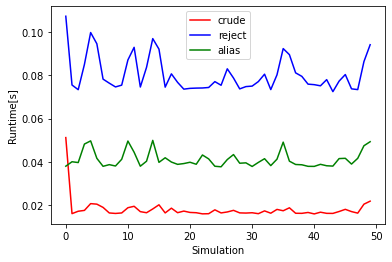

In [ ]:
N_samples = 10000
sims = 50

sC = np.zeros(sims)
sR = np.zeros(sims)
sA = np.zeros(sims)

for s in range(sims):   
    #efficient list methods
    startC = timeit.default_timer()
    ncrude(N_samples)
    stopC = timeit.default_timer()
    
    startR = timeit.default_timer()
    nrejection(N_samples)
    stopR = timeit.default_timer()
    
    startA = timeit.default_timer()
    nalias(N_samples)
    stopA = timeit.default_timer()
    sC[s] = (stopC-startC)
    sR[s] = (stopR-startR)
    sA[s] = (stopA-startA)

plt.plot(sC,color="red",label="crude")
plt.plot(sR,color="blue",label="reject")
plt.plot(sA,color="green",label="alias")
plt.xlabel("Simulation")
plt.ylabel("Runtime[s]")
plt.legend()

plt.show()

It can be observed that the histogrammes are very similar. The runtime of the rejection method is the highest, while the lowest is for the crude method.

<h3> (4) Recommendations

It could be observed that the precision of the methods are sufficient, which means that the best suited method is a question of efficiency. In the test of the runtime it could be seen that the crude method was the fastest - however this is only true for the sampled distribution. The methods each have their own strengths and weaknesses. 

The crude method is very efficient and easy to implement. However, if there was a high number of outcomes (and not just 6) the number of comparisons could easily increase the runtime drastically. Additionally, the method is reliant on the CDF being computed, which could be hard in some special cases. 

The rejection method is probably the easiest method to apply on any given distribution, however, as it could be seen in the runtime-test, it is the slowest of these methods. It could be especially inefficient if a lot of the candidate numbers are rejected.

The alias method is efficient even over a large nmber of samples and outcomes, however it can be difficult to implement, and takes initial time and memory to simply do the setup.


# Exercise 3: Continous distributions

<h3> (1) Sampling from distributions </h3>

(a) Exponential Distribution

We define a utility function to sample from the Exponential Distribution given the parameter lambda.


In [ ]:
def getExp(lam = 1, size = 10000):
    us = np.random.uniform(0,1,size)
    exp = -np.log(us)/lam
    return exp 

Then, we simulated 10000 values using λ = 2 and plotted them using an histogram, along with the
analytical probability density function.

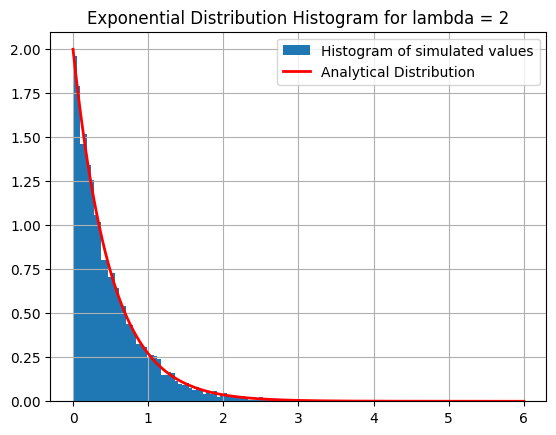

In [ ]:
lam = 2
exp = getExp(lam)
x = np.linspace(0,6, num = 10000)
plt.figure()
plt.hist(exp, bins = 100, density=True, label = 'Histogram of simulated values')
plt.plot(x,lam*np.exp(-lam*x), color = 'red', linewidth = '2', label = 'Analytical Distribution')
plt.plot()
plt.title('Exponential Distribution Histogram for lambda = 2')
plt.legend()
plt.grid()
plt.show()

The visual results are satisfactory, but we also performed tests for distribution type: we used
Kolmogorov Smirnov test to collect a list of p-values that we then plotted using an histogram,
noting how they seem to be uniformly distributed between 0 and 1. This suggests
therefore that our generator indeed samples values from the desired distribution.

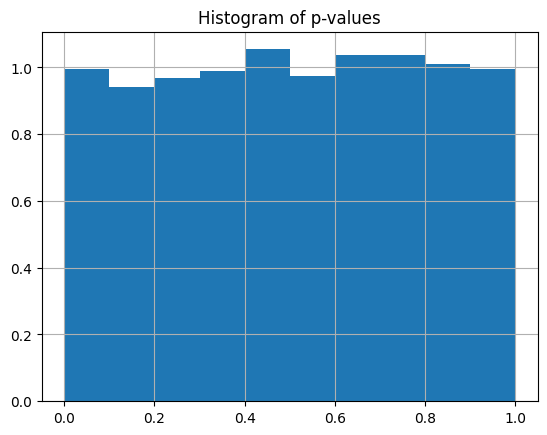

In [ ]:
lam = 2
p = []
for i in range(10000):
    exp = getExp(lam)
    p.append(stats.kstest(exp, cdf = (lambda x: 1 - np.exp(-lam*x)))[1])

plt.figure()
plt.hist(p, density = True)
plt.grid()
plt.title('Histogram of p-values')
plt.show()

(b) Normal Distribution

We define a utility function to sample from the Normal Distribution using the Box Muller method.

In [ ]:
def getNorm(size = 10000):
    u1 = np.random.uniform(0,1,size//2)
    u2 = np.random.uniform(0,1,size//2)
    k = np.sqrt(-2*np.log(u1))
    z1 = k * np.cos(2*np.pi*u2)
    z2 = k * np.sin(2*np.pi*u2)
    z = np.append(z1, z2)
    return z

Again, we sampled 10000 values using the above function and we visually inspected the results
with an histogram.

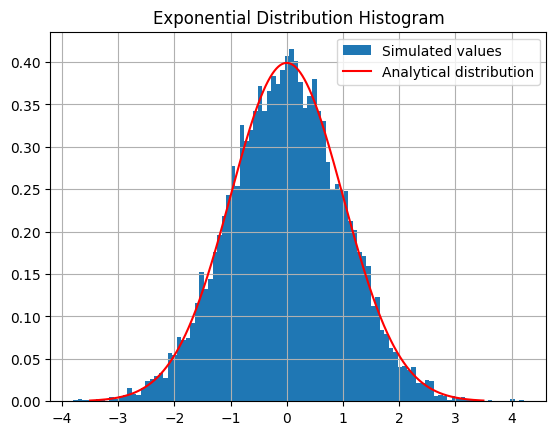

In [ ]:
vals = getNorm()
x = np.linspace(-3.5,3.5, num = 10000)
plt.figure()
plt.hist(vals, bins = 100, density=True, label = 'Simulated values')
plt.plot(x, stats.norm.pdf(x, 0, 1), color = 'red', label = 'Analytical distribution')
plt.plot()
plt.title('Exponential Distribution Histogram')
plt.legend()
plt.grid()
plt.show()

We performed Kolmogorov Smirnov tests to check if our hypothesis (i.e., the sampled values
follow a normal distribution) is respected, generating a set of p-values and seeing that they are
uniformly distributed between 0 and 1: therefore, we can not reject our hypothesis
and we have strong suggestion that indeed we are sampling from the normal distribution.

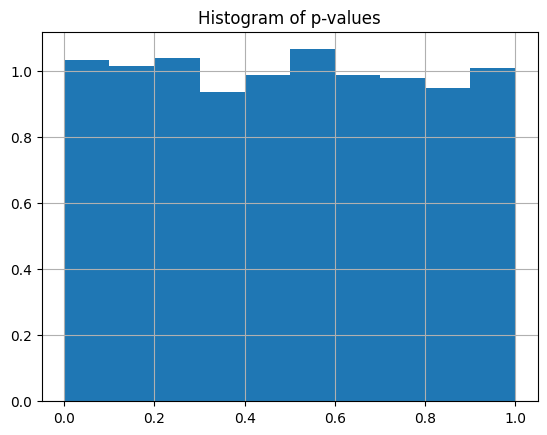

In [ ]:
p = []
for i in range(10000):
    vals = getNorm(lam)
    p.append(stats.kstest(vals, cdf = 'norm')[1])

plt.figure()
plt.hist(p, density = True)
plt.grid()
plt.title('Histogram of p-values')
plt.show()

(c) Pareto

We implemented a function allowing us to generate values from the Pareto distribution, given
the various parameters (with support on [0, ∞[)

In [ ]:
def getPar(k, beta = 1, size = 10000):
    us = np.random.uniform(0, 1, size)
    par = beta*(us**(-1/k)-1)
    return par

We generated simulated values from the above code experimenting with various values of the
first parameter k, as presented in the figure below, along with the real probability density function.

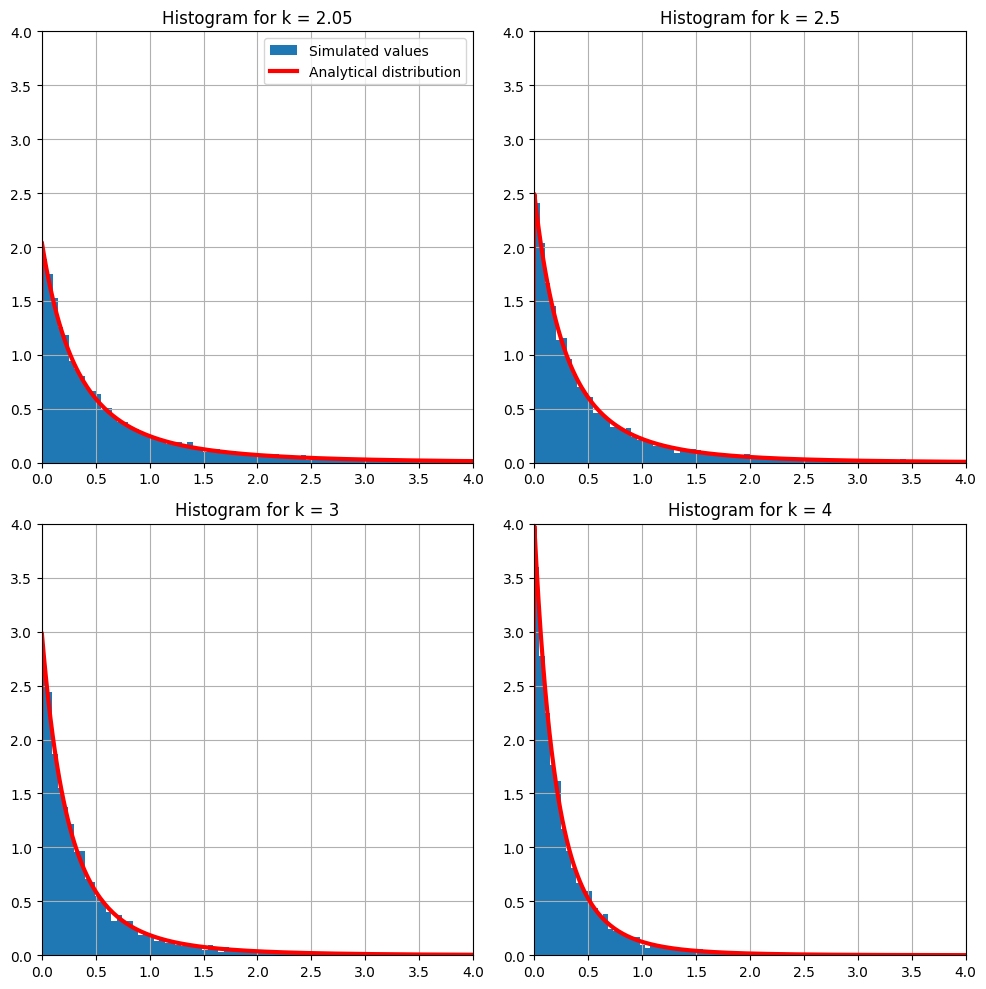

In [ ]:
ks = [2.05, 2.5, 3, 4]

fig, axs = plt.subplots(2,2, figsize = (10,10))
axs = axs.flatten()

for i, k in enumerate(ks):
    vals = getPar(k)
    vals_display = vals[vals<5] #for visualization purposes
    axs[i].hist(vals_display, bins = 100, density = True, label = 'Simulated values')
    x = np.linspace(0,20,1000)
    axs[i].plot(x-1, stats.pareto.pdf(x, k), color = 'red', linewidth = '3', label = 'Analytical distribution')
    axs[i].set_title('Histogram for k = {}'.format(k))
    axs[i].set_xlim([0,4])
    axs[i].set_ylim([0,4])
    axs[i].set_aspect('equal', 'box')
    axs[i].grid()

axs[0].legend()
fig.tight_layout()

As for the exponential and normal distributions, we performed Kolomogorov Smirnov tests on
the sampled values to confirm the hypothesis that they follow correctly the Pareto distribution,
observing how the generated p-values follow the uniform distribution between 0 and 1.

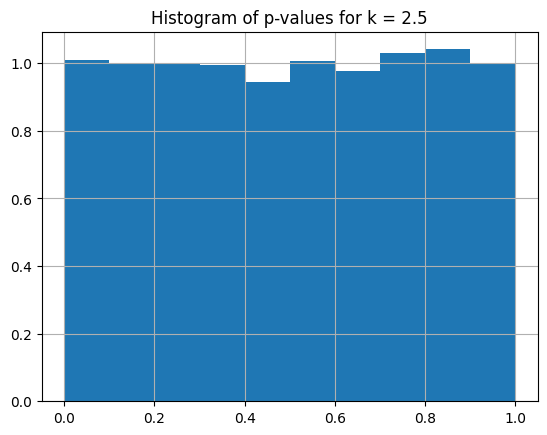

In [ ]:
p = []
for i in range(10000):
    vals = getPar(2.5)
    p.append(stats.kstest(vals, cdf = (lambda x: 1 - (1 + x)**(-2.5)))[1])

plt.figure()
plt.hist(p, density = True)
plt.grid()
plt.title(f'Histogram of p-values for k = {2.5}')
plt.show()

<h3> (2) Pareto Distribution: Mean and Variance analysis</h3>

The following code was used in order to generate values from the Pareto distribution, playing
around with different values of k (assumed to be greater or equal than 2 to get a valid value for
the analytical variance), which stands for the shape parameter of the distribution. The support
for the sampled values was [β, ∞[ (we set β = 1 in the code). For each k, we computed the
analytical and empirical mean and variance, and printed the results

In [ ]:
ks = np.linspace(2.001, 4, 6)
beta = 1.
size = 100000

for k in ks:
    us = np.random.uniform(0, 1, size)
    vals = beta*(us**(-1/k))
    E = beta * k / (k - 1)
    V = beta**2 * k /(k-1)**2/(k-2)
    sample_E = np.mean(vals)
    sample_V = np.std(vals)**2
    print('-----------------\nk = {:.3f}'.format(k))
    print('analytical mean = {:.4f}'.format(E))
    print('empirical mean = {:.4f}'.format(sample_E))
    print('analytical variance = {:.4f}'.format(V))
    print('empirical variance = {:.4f}'.format(sample_V))


#problem when k approaches 2, the sample variance and the analytical
#variance diverge

-----------------
k = 2.001
analytical mean = 1.9990
empirical mean = 2.0132
analytical variance = 1997.0040
empirical variance = 19.8526
-----------------
k = 2.401
analytical mean = 1.7139
empirical mean = 1.7186
analytical variance = 3.0526
empirical variance = 3.6368
-----------------
k = 2.801
analytical mean = 1.5554
empirical mean = 1.5583
analytical variance = 1.0789
empirical variance = 1.3583
-----------------
k = 3.200
analytical mean = 1.4545
empirical mean = 1.4554
analytical variance = 0.5506
empirical variance = 0.5870
-----------------
k = 3.600
analytical mean = 1.3846
empirical mean = 1.3831
analytical variance = 0.3328
empirical variance = 0.3206
-----------------
k = 4.000
analytical mean = 1.3333
empirical mean = 1.3345
analytical variance = 0.2222
empirical variance = 0.2636


During the experiments with k > 2, we noted some problems with the estimation of the variance, while the
estimation of the mean has been proven accurate and stable, given a reasonably large sample
size. More in detail, we noticed how for values of k approaching to 2, the analytical variance
becomes larger and larger, going to infinity at limit. This behavior is not captured by the
empirical value, which is limited by the sample size, thus providing an underestimation
of the true variance. Having larger sample size could help in estimating more accurately the
parameters, but always being aware that for extreme values of k the results might be wrong, since we might need an enormuous amount of samples.

The same reasoning could be applied when we let k be close to 1 and comparing empirical
mean and the analytical mean. Note that, in this case, the analytical variance is not defined

In [ ]:
k = 1.05
beta = 1
us = np.random.uniform(0, 1, size)
vals = beta*(us**(-1/k))
E = beta * k / (k - 1)
sample_E = np.mean(vals)
print('analytical mean = {:.4f}'.format(E))
print('empirical mean = {:.4f}'.format(sample_E))

analytical mean = 21.0000
empirical mean = 10.2306


These results are due to the shape of the Pareto Distribution, which has a long right tail.

<h3> (3) Confidence intervals for the Normal Distribution </h3>

We generated one hundred Confidence Intervals with confidence level equal to 95%, each one
based on ten observations from the normal distribution.

In [ ]:
from scipy.stats import t
n = 10
ci = np.zeros((100,4))
CL = 0.95 # confidence level
DF = n-1 # degrees of freedom
z = np.abs(t.ppf((1-CL)/2,DF ) )
for i in range(100):
    u1 = np.random.rand(n)
    u2 = np.random.rand(n)
    x1 = np.sqrt(-2*np.log(u1) ) * np.cos(2*np.pi*u2)
    m = np.mean(x1) 
    s = np.std(x1)
    pm = z * s/np.sqrt(n)
    ci[i,:] = [m+pm, m-pm,m,s]


We print some interesting results for the run

In [ ]:
# compute how many confidence intervals do not contain the true mean
not_covered = np.sum(np.logical_or(ci[:100,0] < 0, ci[:100,1] > 0))
print('Number of Confidence intervals that do not cover the true parameter: ', not_covered)
      
# compute the average width of the confidence interval
avg_width = np.mean(np.array(ci[:100,0]-np.array(ci[:100,1])))
print('average width of the confidence intervals: ', avg_width)

Number of Confidence intervals that do not cover the true parameter:  7
average width of the confidence intervals:  1.2834223738697108


The generated Confidence Intervals are then plotted to get a visual result

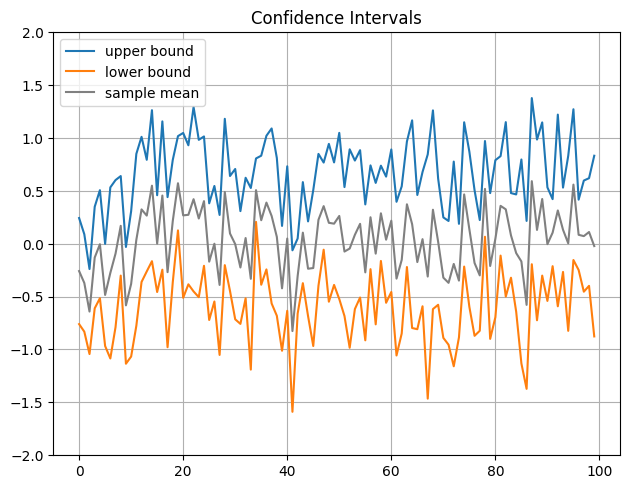

In [ ]:
plt.plot(ci[:100,0], label = 'upper bound')
plt.plot(ci[:100,1], label = 'lower bound')
plt.plot(ci[:100,2], color="gray", label = 'sample mean')
plt.grid()
plt.legend()
plt.tight_layout()
plt.title('Confidence Intervals')
plt.ylim(-2,2)
plt.show()

Given the confidence level, we expect that 95 out of the 100 generated confidence intervals
capture the true mean of the standard normal distribution, i.e. the interval contains the value
0. This fact is respected by our experiments, even if we observed some variability in
the results, as one could expect by observing that each confidence interval is based only on
ten generated observations. This uncertainty is also highlighted by the average width of the
confidence intervals: trying to have a larger sample size, we observed more robust results with less variability and much thinner confidence
intervals

<h3> (4) Pareto Distribution using Composition </h3>

The following code is able to generate simulated values from the Pareto Distribution
using composition, as presented in the lecture slides. The results are then plotted noting that using composition we have simulated the Pareto
distribution with parameters β = 1 and k = 1.

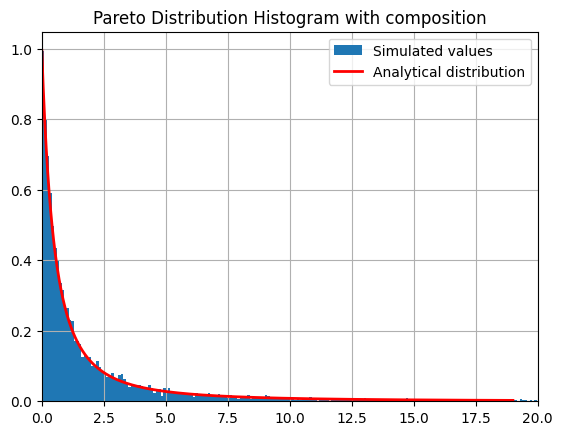

In [ ]:
mu = 1.
vals = []
for i in range(10000):
    u1= np.random.uniform(0,1)
    y = -np.log(u1)/mu
    u2 = np.random.uniform(0,1)
    vals.append(-np.log(u2)/y)

vals = np.array(vals)
vals = vals[vals < 20]
x = np.linspace(0,20,1000)
plt.hist(vals, bins = 200, density = True, label = 'Simulated values')
plt.xlim([0,20])
plt.plot(x-1, stats.pareto.pdf(x, 1), color = 'red', linewidth = '2', label = 'Analytical distribution')
plt.legend()
plt.grid()
plt.title('Pareto Distribution Histogram with composition')
plt.show()


# Exercise 4: Discrete event simulation

<h3>(1) Simulate blocking system</h3>

In [ ]:
def simulate_blocking_system(arrival_intensity = 1, mean_service_time = 8, num_servers = 10, n = 10000, 
                             arrival_mode = 'poisson', service_mode = 'exponential', service_params = {}):
    """
        Simulate simple blocking system with discrete events and no waiting room.
    """
    t_system = 0
    m = num_servers
    servers = np.zeros(m)
    blocked = 0 # Counter of number of blocked
    busy_servers = np.zeros(n, dtype=int)

    for i in range(n):
        # Sample time from which this customer arrives
        if arrival_mode == 'poisson':
            t_arrival = stats.expon.rvs(scale=arrival_intensity, size = 1)
        elif arrival_mode == 'erlang':
            t_arrival = stats.erlang.rvs(a = 2, scale=arrival_intensity / 2, size = 1)
        elif arrival_mode == 'hyper':
            t_arrival = rvs_hyperexponential(p = 0.8, lambda_1 = 0.8333, lambda_2 = 5.0)
        else:
            raise ValueError('Wrong arrival mode specified!')
        
        # Extend system time
        t_system += t_arrival

        # Find available server
        min_server_idx = np.argmin(servers)

        if t_system >= servers[min_server_idx]:
            if service_mode == 'exponential':
                t_service = stats.expon.rvs(scale=mean_service_time, size = 1)
            elif service_mode == 'constant':
                t_service = mean_service_time
            elif service_mode == 'pareto':
                k = service_params.get('k')
                t_service = rvs_pareto(mean_ = mean_service_time, k = k, size = 1)
            elif service_mode == 'normal':
                s = service_params.get('s')
                val = stats.norm.rvs(loc = mean_service_time, scale = s, size = 1)
                if val < 0:
                    val = 0
                t_service = val
            else:
                raise ValueError('Wrong service mode specified')
            servers[min_server_idx] = t_system + t_service
        else:
            blocked += 1

        busy_servers[i] = np.sum(servers > t_system)

    # Compute blocked fraction
    blocked_fraction = blocked / n

    return blocked_fraction, busy_servers

def rvs_hyperexponential(p = 0.8, lambda_1 = 0.83, lambda_2 = 5.0, size = 1):    
    choices = stats.binom.rvs(p = 1 - p, n = 1, size = size)
    results = np.zeros(size)

    for i, choice in enumerate(choices):
        if choice == 0:
            results[i] =  stats.expon.rvs(scale = 1 / lambda_1, size = 1)    
        else:
            results[i] = stats.expon.rvs(scale = 1 / lambda_2, size = 1)

    return results

def rvs_pareto(mean_ = 8, k = 1.05, size = 1):
    # Find the value of Beta
    beta = mean_ * (k - 1) / k

    # Generate uniform numbers 
    U = np.random.uniform(0, 1, size = size)
    X = beta * (U ** (-1/k))

    return X

def confidence_interval(vals, alpha = 0.05):
    if type(vals) != np.ndarray:
        vals = np.array(vals)

    n = len(vals)

    mean_ = np.mean(vals)
    std_error = np.sqrt( 1 / (n - 1) * np.sum((vals - mean_) ** 2))

    t = stats.t.ppf(1 - (alpha / 2), df = n - 1 )

    conf = [mean_ - t * std_error / np.sqrt(n), mean_ + t * std_error / np.sqrt(n)]

    return np.array(conf)

def analytical_blocking_system(arrival_intensity = 1, mean_service_time = 8, num_servers = 10):
    lambda_ = arrival_intensity
    s = mean_service_time
    m = num_servers
    A = lambda_ * s

    temp = np.array([A ** i / np.math.factorial(i) for i in np.arange(0, m + 1, 1)])

    B = (A ** m / np.math.factorial(m)) / (temp.sum())

    return B


Compute analytical solution and compare to the confidence interval of the simulated solution

In [ ]:
simulated_fractions = []

for i in range(10):
    blocked_fraction, busy_servers = simulate_blocking_system()
    simulated_fractions.append(blocked_fraction)

conf = confidence_interval(simulated_fractions)

analytical_blocked_fraction = analytical_blocking_system() 

print_conf = conf * 100

print(f'Simulated Blocked fraction confidence interval: [{print_conf[0]:.2f}%, {print_conf[1]:.2f}%]')
print(f'Analytical Blocked fraction: {analytical_blocked_fraction * 100:.2f}%')

Simulated Blocked fraction confidence interval: [11.81%, 13.08%]
Analytical Blocked fraction: 12.17%


The analytical solution is inside the confidence interval of the simulated solution, indicating that the simulation is performing well. We can also see how many servers are busy in steady state of the simulation to see if there are any errors. Here the number of busy servers are sampled each time we have an arrival.

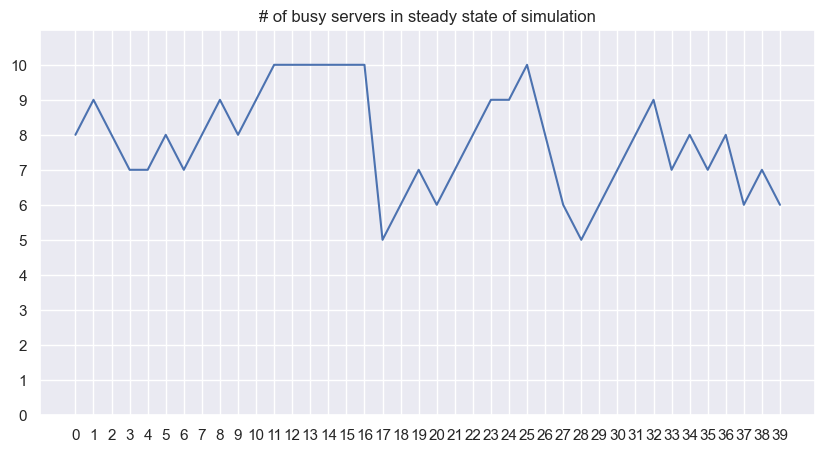

In [ ]:
fig, ax = plt.subplots(1, figsize = (10, 5))
ax.set_xticks(np.arange(0, 40))
ax.set_yticks(np.arange(0, 11))
ax.set_ylim(0, 11)
ax.plot(busy_servers[1000:1040])
ax.set_title(f'# of busy servers in steady state of simulation')
plt.show()

<h3>(2) Experiment with different distributions of arrival time</h3>

We run simulations with each of the arrival functions 10 times and report a confidence interval of the blocked fraction.

In [ ]:
def experiment_arrival_time_distributions():
    arrival_modes = ['poisson', 'erlang', 'hyper']

    print('Blocked fraction values of different arrival modes')
    print('-' * 50)
    for mode in arrival_modes:

        rounds = 10

        block_sims = np.zeros(rounds)

        for r in range(rounds):
            block_sims[r], _ = simulate_blocking_system(arrival_mode=mode)

        conf_int = confidence_interval(block_sims, alpha = 0.05)
        print_conf_int = conf_int * 100

        print(f'arrival mode: {mode}, conf_int = [{print_conf_int[0]:.2f}%, {print_conf_int[1]:.2f}%]')

experiment_arrival_time_distributions()

Blocked fraction values of different arrival modes
--------------------------------------------------
arrival mode: poisson, conf_int = [11.86%, 12.77%]
arrival mode: erlang, conf_int = [8.71%, 9.23%]
arrival mode: hyper, conf_int = [13.66%, 14.37%]


For the Erlang distribution we use values $k = 2$ and $\lambda = \frac{1}{2}$ to get result that are different than that of the exponential distribution. We see that the confidence interval of the blocked fraction for this distribution is lower than the others wihile the hyperexponential has the highest estimate of the blocked fraction. We can plot histograms of the sampling distribution to understand why this might be the case.

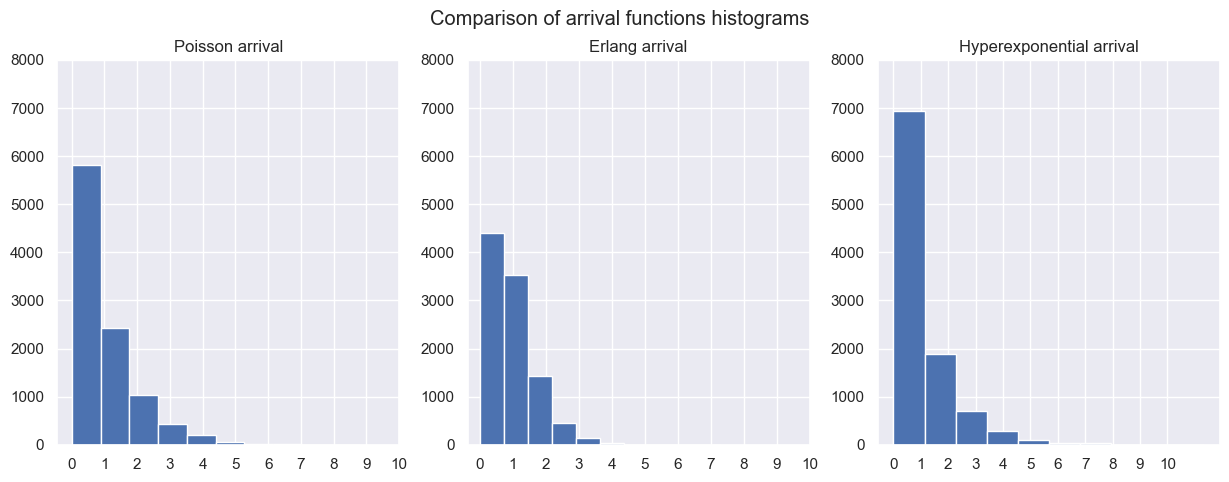

In [ ]:
n_bins = 10
n_sample = 10000

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].hist(stats.expon.rvs(scale = 1, size = n_sample), bins = n_bins)
ax[1].hist(stats.erlang.rvs(a = 2, scale = 1 / 2, size = n_sample), bins = n_bins)
ax[2].hist(rvs_hyperexponential(p = 0.8, lambda_1 = 0.8333, lambda_2 = 5.0, size = n_sample), bins = n_bins)

ax[0].set_title('Poisson arrival')
ax[1].set_title('Erlang arrival')
ax[2].set_title('Hyperexponential arrival')

for i in range(3):
    ax[i].set_xticks(np.arange(0, 11, 1))
    ax[i].set_ylim(0, 8000)

fig.suptitle('Comparison of arrival functions histograms')


plt.show()

We see from the plot above that for the hyperexponential the arrival time is lower than 1 time unit 70 % of the time, which would explain why the blocked fraction is the highest for this sampling distbrution. For the erlang arrival we see that the arrival times are distributed more evenly and consequently the servers will have more time to complete their tasks before the next arrival. 

<h3>(3) Experiment with different service-time distributions</h3>

We run the simulation ten times for each distribution for sampling service times and calculate the 95% confidence interval of the blocked fraction.

In [ ]:
def experiment_service_mode_distributions():
    service_modes = ['exponential', 'constant', 'pareto', 'pareto', 'normal']
    service_params = [{}, {}, {'k' : 1.05}, {'k' : 2.05}, {'s' : 2}]

    print('Blocked fraction values of different service modes')
    print('-' * 50)
    for i, mode in enumerate(service_modes):

        rounds = 10

        block_sims = np.zeros(rounds)

        for r in range(rounds):
            block_sims[r],_ = simulate_blocking_system(service_mode=mode, service_params=service_params[i])

        conf_int = confidence_interval(block_sims, alpha = 0.05)
        print_conf_int = conf_int * 100

        print(f'service mode: {mode}, params: {service_params[i]}, conf_int = [{print_conf_int[0]:.2f}%, {print_conf_int[1]:.2f}%]')

experiment_service_mode_distributions()

Blocked fraction values of different service modes
--------------------------------------------------
service mode: exponential, params: {}, conf_int = [11.60%, 12.72%]
service mode: constant, params: {}, conf_int = [11.95%, 12.56%]
service mode: pareto, params: {'k': 1.05}, conf_int = [0.01%, 0.19%]
service mode: pareto, params: {'k': 2.05}, conf_int = [11.92%, 12.54%]
service mode: normal, params: {'s': 2}, conf_int = [11.57%, 12.18%]


We see similar results for the different service modes as for arrival times. For the pareto distribution with $k = 1.05$ we get next to no blocked customers. This is because, even though the mean of the distribution is the same as the others, it has a lot of very low service times and a low chance to get extremely high values. The simulation is robust to a few high service time samples as there are many servers available, which would explain why the blocked fraction is so low. This is not the case for pareto with $k = 2$ and the other distribution functions, which all have quite similar confidence intervals of the blocked fraction. The size of the confidence interval is the lowest for the constant service time (except pareto with $k = 1.05$), which makes sense as there is much less variability between each run.

<h3>(4) Compare differences in confidence intervals for prior tasks</h3>

In [ ]:
experiment_arrival_time_distributions()
print()
experiment_service_mode_distributions()

Blocked fraction values of different arrival modes
--------------------------------------------------
arrival mode: poisson, conf_int = [11.57%, 12.48%]
arrival mode: erlang, conf_int = [9.05%, 9.67%]
arrival mode: hyper, conf_int = [13.01%, 14.12%]

Blocked fraction values of different service modes
--------------------------------------------------
service mode: exponential, params: {}, conf_int = [11.93%, 12.89%]
service mode: constant, params: {}, conf_int = [11.60%, 12.56%]
service mode: pareto, params: {'k': 1.05}, conf_int = [0.04%, 0.37%]
service mode: pareto, params: {'k': 2.05}, conf_int = [11.65%, 12.12%]
service mode: normal, params: {'s': 2}, conf_int = [11.88%, 12.12%]


See exercises (1) - (3) for comments on blocked fractions of the different arrival- and service distributions.

# Exercise 5: Variance reduction methods

We define a function to generate a confidence interval given a vector of sampled values

In [ ]:
def getCI(vals):
    n = len(vals)
    CL = 0.95 # confidence level
    DF = n-1 # degrees of freedom
    z = np.abs(stats.t.ppf((1-CL)/2,DF))
    mean = np.mean(vals)
    std = np.std(vals, ddof = 1)
    u = mean + z*std/np.sqrt(n)
    l = mean - z*std/np.sqrt(n)
    return mean, l, u

<h3> (1) Estimate integral using crude Monte Carlo </h3>

We sample 100 values from the uniform distribution and apply the crude method to get the estimate of the integral.

In [ ]:
us = np.random.uniform(0,1, size = 100)
exp = np.exp(us)
print('The variance of the estimation is: {:.4f}'.format(np.var(exp)))
mean, l, u = getCI(exp)
print('The estimate of the integral is: {:.4f}'.format(mean))
print('With the following confidence interval: {:.4f}, {:.4f}'.format(l,u))
print('Analytical solution of the integral: {:.4f}'.format(np.e - 1))

The variance of the estimation is: 0.2261
The estimate of the integral is: 1.6194
With the following confidence interval: 1.5246, 1.7143
Analytical solution of the integral: 1.7183


<h3> (2) Estimate integral using antithetic variables </h3>

We sample 100 values from the uniform distribution and we estimate the integral using antithetic variables

In [ ]:
us = np.random.uniform(0,1, size = 100)
exp = np.exp(us)
y = (exp + np.e/exp)/2

print('The variance of the estimation is: {:.4f}'.format(np.var(y)))
mean, l, u = getCI(y)
print('The estimate of the integral is: {:.4f}'.format(mean))
print('With the following confidence interval: {:.4f}, {:.4f}'.format(l,u))
print('Analytical solution of the integral: {:.4f}'.format(np.e - 1))

The variance of the estimation is: 0.0040
The estimate of the integral is: 1.7177
With the following confidence interval: 1.7051, 1.7303
Analytical solution of the integral: 1.7183


Note that the variance is reduced a lot with respect to the crude method

<h3> (3) Estimate integral using control variates </h3>

In [ ]:
us = np.random.uniform(0,1, size = 100)
exp = np.exp(us)
c = -np.cov(exp, us)[0,1]/np.var(us)
z = exp + c*(us - 1/2)
print('The variance of the estimation is: {:.4f}'.format(np.var(z)))
mean, l, u = getCI(z)
print('The estimate of the integral is: {:.4f}'.format(mean))
print('With the following confidence interval: {:.4f}, {:.4f}'.format(l,u))
print('Analytical solution of the integral: {:.4f}'.format(np.e - 1))

The variance of the estimation is: 0.0041
The estimate of the integral is: 1.7233
With the following confidence interval: 1.7106, 1.7360
Analytical solution of the integral: 1.7183


Also in this case the variance is reduced with respect the crude method.

<h3> (4) Estimate integral using stratified sampling </h3>

We use stratified sampling with 10 strata to get the estimate of the integral. Using this method we are able to reduce the variance of the estimation by another order of magnitude

In [ ]:
w = [] # The final list will contain ten values for the estimation of the integral
for i in range(10):
    us = np.random.uniform(0,1,10) # Each sample is based on ten uniformly distributed values
    w.append(np.sum([np.exp((j + us[j])/10) for j in range(10)])/10) # Stratified sampling

print('The variance of the estimation is: {:.4f}'.format(np.var(w)))
mean, l, u = getCI(w)
print('The estimate of the integral is: {:.4f}'.format(mean))
print('With the following confidence interval: {:.4f}, {:.4f}'.format(l,u))
print('Analytical solution of the integral: {:.4f}'.format(np.e - 1))

The variance of the estimation is: 0.0002
The estimate of the integral is: 1.7141
With the following confidence interval: 1.7039, 1.7242
Analytical solution of the integral: 1.7183


We can note that in all the cases we got quite accurate estimations of the integral, but with different estimations of the variance. In detail, the crude Monte Carlo estimation has the most variance, which is then reduced in the other methods. This is reflected also by the width of the confidence intervals.

<h3> (5) Control variates for blocking queueing system simulation </h3>

We use the control variate method to reduce the variance in the estimation of the blocked fraction of customers in the queueing system problem. As control variate, we use the mean arrival time in the simulation.

The following function simulates the problem using a Poisson process for the arrivals and exponential service times. It returns the fraction of blocked customers and the mean arrival time.

In [ ]:
def simulate_queue(nserver, customers, mean_st, mean_tbc):
    server_time = np.zeros(nserver)
    time = 0
    blocked = 0
    t_arrival_time = 0
    for _ in range(customers):
        delta_arrival_time = stats.expon.rvs(scale = mean_tbc, size = 1)[0]
        t_arrival_time += delta_arrival_time
        time += delta_arrival_time
        min_server = np.min(server_time)
        idx_min_server = np.argmin(server_time)
        if time < min_server:
            blocked +=1
        else:
            delta_service_time = stats.expon.rvs(scale = mean_st, size = 1)
            server_time[idx_min_server] = time + delta_service_time
    
    return blocked/customers, t_arrival_time/customers

We initialize some parameters of interest

In [ ]:
nserver = 10 # number of service units
mean_st = 8 # mean service time
mean_tbc = 1 # mean time between customers
customers = 10000 #number of customers for each simulation
nsim = 10 # number of simulations

Then we perform ten simulations, saving for each one the fraction of blocked customers and the mean arrival time

In [ ]:
runs = [] # this list will contain the fraction of blocked customers for each simulation
arrivals = [] # this list will contain the mean arrival time for each simulation
for i in range(nsim):
    blocked, arrival = simulate_queue(nserver, customers, mean_st, mean_tbc)
    runs.append(blocked)
    arrivals.append(arrival)

We use the control variates method to reduce the variance in the estimation

In [ ]:
runs = np.array(runs)
arrivals = np.array(arrivals)

c = -np.cov(runs, arrivals)[0,1]/np.var(arrivals)

z = runs + c*(arrivals - mean_tbc)

mean_r, l_r, u_r = getCI(runs)
mean_z, l_z, u_z = getCI(z)

print('The estimate of the fraction of blocked customers (without variance reduction) is: {:.4f}'.format(mean_r))
print('With the following confidence interval: {:.4f}, {:.4f}\n'.format(l_r,u_r))

print('The estimate of the fraction of blocked customers (with variance reduction) is: {:.4f}'.format(mean_z))
print('With the following confidence interval: {:.4f}, {:.4f}'.format(l_z,u_z))

print('The variance without control variates is:',np.var(runs))
print('The variance with control variates is:',np.var(z))

The estimate of the fraction of blocked customers (without variance reduction) is: 0.1208
With the following confidence interval: 0.1158, 0.1257

The estimate of the fraction of blocked customers (with variance reduction) is: 0.1196
With the following confidence interval: 0.1168, 0.1224
The variance without control variates is: 4.362840000000002e-05
The variance with control variates is: 1.4024515859755557e-05


We can note that the variance has been reduced using control variates

<h3> (6) Common random numbers in queueing system simulation </h3>

We define two functions able to sample from the exponential and hyperexponential distributions given some samples drawn from the uniform distribution passed as parameters.

In [ ]:
def getExp(lam, us):
    exp = -np.log(us)/lam
    return exp 

def getHyperExp(p, lam1, lam2, u1, u2):
    res = np.zeros(len(u1))
    res[u2 <= p] = getExp(lam = lam1, us = u1[u2 <=p])
    res[u2 > p] = getExp(lam = lam2, us = u1[u2 > p])
    return res

For the Common Random Numbers method to work, we need to ensure that the two systems (one having exponential inter-arrival times, the other hyperexponential), run on the same sequence of random numbers, uniformly distributed between 0 and 1. To do so, we let the caller of the function set a seed that is then used to sample the sequence of values used to obtain the arrival times. The aim is to call the function in both types 'Exp' (corresponding to exponential arrival times) and 'Hyp' (hyperexponential arrival times) with the same seed, so we can fairly compare the results.

In [ ]:
def simulate_queue_q2(nserver, customers, mean_st, mean_tbc, type = 'Exp', seed = 0):
    np.random.seed(seed)
    u1 = np.random.uniform(0,1, customers)
    u2 = np.random.uniform(0,1, customers)
    server_time = np.zeros(nserver)
    time = 0
    blocked = 0
    if type == 'Exp':
        arrival_times = getExp(lam = mean_tbc, us = u1)
    elif type == 'Hyp':
        arrival_times = getHyperExp(0.8, 0.8333, 5, u1, u2)
    for i in range(customers):
        delta_arrival_time = arrival_times[i]
        time += delta_arrival_time
        min_server = np.min(server_time)
        idx_min_server = np.argmin(server_time)
        if time < min_server:
            blocked += 1
        else:
            server_time[idx_min_server] = time + stats.expon.rvs(scale = mean_st, size = 1)
    
    return blocked/customers

We initialize the parameters

In [ ]:
nserver = 10
mean_st = 8
mean_tbc = 1
customers = 10000
nsim = 10

We perform ten simulations of the two processes using ten different seeds, saving the blocked fraction of customers for each run. Then we perform a paired t-test to see if there is a difference between the two processes.

In [ ]:
runs = []
for i in range(10):
    runs.append([simulate_queue_q2(nserver, customers, mean_st, mean_tbc, 'Hyp', i), simulate_queue_q2(nserver, customers, mean_st, mean_tbc, 'Exp', i)])

runs = np.array(runs)

print(stats.ttest_rel(runs[:,0], runs[:,1]))
print('Estimated difference between the two processes: {:.4f}'.format(np.mean(runs[:,0] - runs[:,1])))

Ttest_relResult(statistic=16.68412262034125, pvalue=4.462657602263569e-08)
Estimated difference between the two processes: 0.0191


The p-value is very low, indicating a strong suggestion that the two processes perform differently. The estimation of the difference in performance is almost 2%, as printed above

<h3> (7) Monte Carlo on standard normal random variable </h3>

First, we use the crude Monte Carlo method to estimated the desired probability, sampling 10000 values from the standard normal distribution and seeing how many are above the threshold. This will give a rough estimate of the probability. 

In [ ]:
a = 4
tot = 10000
values = np.random.randn(tot) > a

mean, l, u = getCI(values)
print('The estimate of the probability is: {:.6f}'.format(mean))
print('With the following confidence interval: {:.6f}, {:.6f}'.format(l,u))
print('The true value for the probability is: {:.6f}'.format(1 - stats.norm.cdf(a)))

The estimate of the probability is: 0.000100
With the following confidence interval: -0.000096, 0.000296
The true value for the probability is: 0.000032


Using a=2 we get somewhat accurate estimation of the probability, while for a=4 the result is much worse, because we are estimating the probability of a more extreme outcome and crude Monte Carlo struggles to estimate it with few samples. We would therefore need more samples to estimate it correctly.

The problem can be solved using Importance Sampling as follows, always using 10000 samples.

In [ ]:
a = 4
s = 1
tot = 10000

samples = stats.norm.rvs(loc = a, scale = s, size = tot)

h = samples > a
f = stats.norm.pdf(samples)
g = stats.norm.pdf(samples, loc = a, scale = s)

Z = h * f / g

mean, l, u = getCI(Z)
print('The estimate of the probability is: {:.6f}'.format(mean))
print('With the following confidence interval: {:.6f}, {:.6f}'.format(l,u))
print('The true value for the probability is: {:.6f}'.format(1 - stats.norm.cdf(a)))

The estimate of the probability is: 0.000033
With the following confidence interval: 0.000031, 0.000034
The true value for the probability is: 0.000032


<h3> (8) Exponential importance sampling </h3>

We include a photo for the derivation of the value of λ which minimizes the required variance

![picture 1](resources/cce642c549bddefeb7e43662c6ea703da81334325ef94f3f5ae6f03b234186fb.png)  


We verify the result using simulation, using the value of λ found analytically

In [ ]:
lam = 1.35483
size = 100000

values = stats.expon.rvs(scale = 1/lam, size = size) # we get values from the sample distribution g

f = np.logical_and(values <= 1, values>=0)
h = np.exp(values)
g = lam*np.exp(-lam*values)

res = f * h / g

mean, l, u = getCI(res)
print('The estimate of the integral is: {:.4f}'.format(mean))
print('With the following confidence interval: {:.4f}, {:.4f}'.format(l,u))
print('Analytical solution of the integral: {:.4f}'.format(np.e - 1))
print('The estimated variance is the following: {:.4f}'.format(np.var(res, ddof = 1)))

The estimate of the integral is: 1.7278
With the following confidence interval: 1.7168, 1.7388
Analytical solution of the integral: 1.7183
The estimated variance is the following: 3.1552


We can see that we have a good estimation of the integral, but with a large variance with respect to the method used in the first exercises of this notebook. Therefore probably using this sampling distribution is not a good idea.

<h3> (9) Pareto IS estimator </h3>

We perform importance sampling for the estimation of the mean for the Pareto distribution. The sampling distribution is the first moment distribution: in the Pareto case, this is distributed again as a Pareto with the k parameter decreased by 1. Note that we use β = 1.

In [ ]:
k = 1.05
size = 10000
values = stats.pareto.rvs(k-1, size = size) # getting values from the sampling distribution

h = values
f = stats.pareto.pdf(values, k)
g = stats.pareto.pdf(values, k-1)

res = h * f / g

mean, l, u = getCI(res)
print(f'The estimate of the mean is: {mean}')
print(f'With the following confidence interval: {l},{u}')
print(f'Analytical value of the mean: {k/(k-1)}')

The estimate of the mean is: 21.000000000000075
With the following confidence interval: 21.00000000000007,21.000000000000078
Analytical value of the mean: 20.999999999999982


Using importance sampling in this case is very helpful since it allows to estimate the mean with very high precision: this task is very difficult with the simple estimation, as seen in exercise 3. In question 8 we could use an exponential function (increasing with x) so that the variance of the estimation is reduced, since the sampling distribution follows more the shape of the function in the original integral.

# Exercise 6: Markov chain Monte Carlo

<h3> (1) Truncated Poisson using Metropolis-Hastings </h3>

The following function evaluates the unnormalized distribution:

In [ ]:
def g(A, i):
    return A**i/np.math.factorial(i)

We also define a function able to compute the true probability distribution for the truncated Poisson, to be compared with the results of the Metropolis Hastings algorithm.

In [ ]:
def poisson():
    n = 10
    A = 8
    d = np.empty(n+1)
    for j in range(n+1):
        d[j] = g(A,j)
    return d/np.sum(d)

The Metropolis Hastings algorithm is implemented by the following function:

In [ ]:
def metropolis_hastings(init = 0, size = 10000):
    A = 8
    m = 10
    res = [init] # res contains the final sampled values
    n = 1
    x = init
    while n < size:
        
        # sampling the new proposal
        delta = np.random.randint(-m,m+1)
        y = np.mod(x + delta, m+1)
        gy = g(A, y)
        gx = g(A, x)

        #acceptance or rejection of the proposal
        if gy >= gx:
            res.append(y)
            x = y
        else:
            p = np.random.rand(1)
            if (p < gy/gx):
                res.append(y)
                x = y
            else:
                res.append(x)
        n += 1
    return res

For visual purposes, we plot the histogram of the sampled values, along with the true probability distribution.

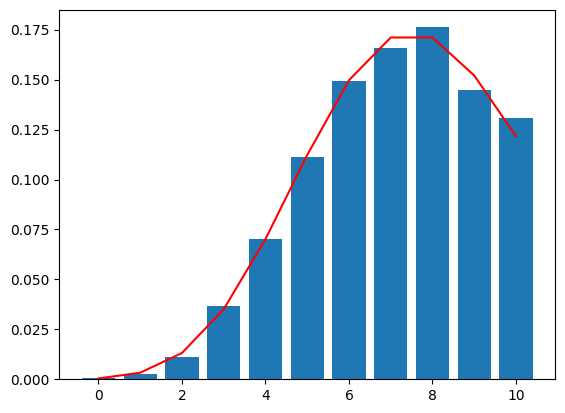

In [ ]:
vals = metropolis_hastings()
unique = np.unique(vals)
counts = np.empty(11)
for i,u in enumerate(unique):
    counts[i] = np.sum(vals == u)

plt.bar(range(11), counts/len(vals))
plt.plot(poisson(), color = 'Red')
plt.show()

From the plot, it seems we achieved the desired result, but we also performed a set of χ2 tests. Then, we plot the histogram of the found p-values. Note that at each iteration, when sampling new values, we save only every four samples to reduce the dependence of one sample with the others, otherwise we would not satisfy the assumptions of the χ2 test. 

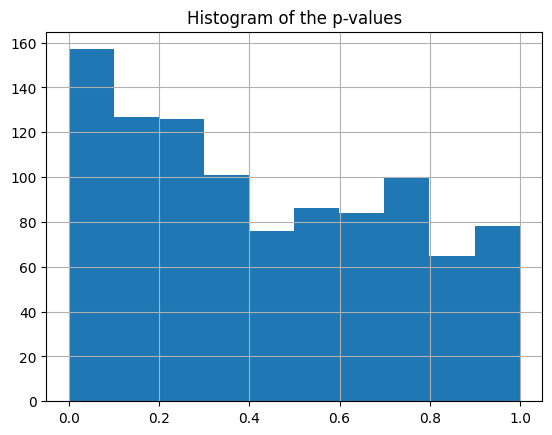

In [ ]:
p_values = []
for i in range(1000):
    vals = metropolis_hastings()[::4] # the values are dependent with each other
    unique = np.unique(vals)
    counts = np.empty(11)
    for i,u in enumerate(unique):
        counts[i] = np.sum(vals == u)
    p_values.append(stats.chisquare(counts, poisson()*len(vals))[1])

plt.hist(p_values)
plt.title('Histogram of the p-values')
plt.grid()
plt.show()

The distribution of the p-values is somewhat uniform (there is still a little dependence between the samples). Overall, we can conclude that our implementation of the algorithm is satisfactory and gives the desired results

<h3> (2) Metropolis-Hastings in 2D </h3>

We define a utility function able to display the results given by our implementations of the algorithms, along with the true distribution for comparison.

In [ ]:
def show_comparison2D(estimated, true_frequency):
    counts = np.empty((11,11))
    for i in range(11):
        for j in range(11):
            counts[i,j] = np.sum(np.logical_and(estimated[:,0]==i, estimated[:,1]==j))
            
    fig, axs = plt.subplots(1,2, figsize = (12,12))
    axs[0].imshow(counts, cmap = 'gray')
    axs[0].set_title('Estimated Frequency')
    axs[1].imshow(true_frequency, cmap = 'gray')
    axs[1].set_title('True Frequency')
    plt.show()

The following function evaluates the unnormalized distribution:

In [ ]:
def g_2D(A1, A2, i, j):
    return A1**i/np.math.factorial(i)*A2**j/np.math.factorial(j)

We also need to have the true values of the distribution when comparing the results of the asked algorithms:

In [ ]:
def poisson2D():
    res = np.zeros((11,11))
    for i in range(11):
        for j in range(0, 11 - i):
            res[i,j] = g_2D(4,4,i,j)
    return res/np.sum(res)

For question 2a, we implement the proposal distribution as a function able to generate new states uniformly. In other words, the output of the function is a pair [i, j] where 0 <= i + j <= 10. There are therefore 66 possible states.

In [ ]:
possible_states = [[i, j] for i in range(11) for j in range(11 - i)]

def getNewIJ():
    idx = int(np.floor(np.random.uniform(0,1)*66))
    return possible_states[idx]

The algorithm is implemented as follows

In [ ]:
def metropolis_hastings2D(init = [0,0], size = 100000):
    A1 = 4
    A2 = 4
    m = 10

    res = np.empty((size,2))
    n = 1
    res[0,:] = init
    i = init[0]
    j = init[1]

    while n < size:
        
        #sampling a new proposal
        new_i, new_j = getNewIJ()

        #acceptance or rejection of the proposal
        gy = g_2D(A1, A2, new_i, new_j)
        gx = g_2D(A1, A2, i, j)
        if gy >= gx:
            res[n,:] = [new_i, new_j]
            i = new_i
            j = new_j
        else:
            p = np.random.rand(1)
            if (p <= gy/gx):
                res[n,:] = [new_i, new_j]
                i = new_i
                j = new_j
            else:
                res[n,:] = [i,j]
        n += 1
    return res

We visualize the results given by the algorithm to see if they are similar to the true distribution

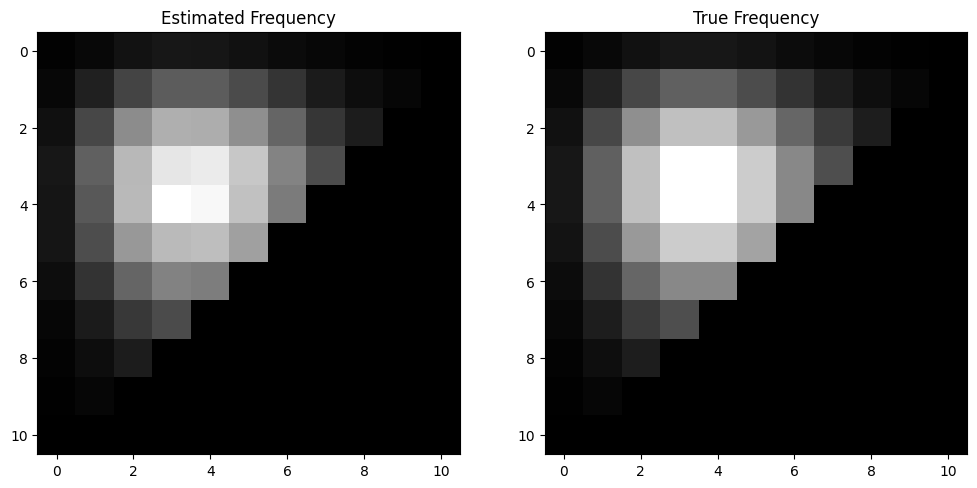

In [ ]:
vals = metropolis_hastings2D()
show_comparison2D(vals, poisson2D()*vals.shape[0])

We also perform χ2 tests to see if the p-values are uniformly distributed between 0 and 1. We keep one sample every four to reduce the dependence between the values.

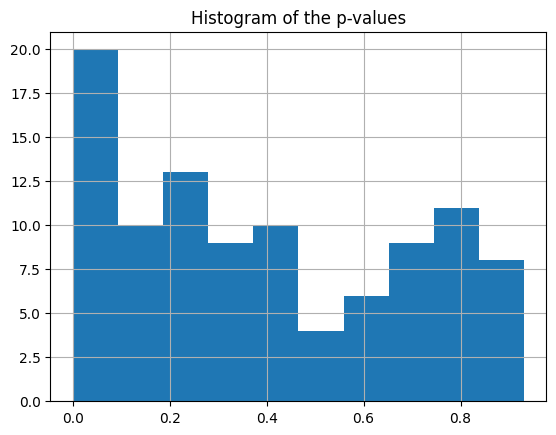

In [ ]:
true_f = poisson2D()
mask = true_f !=0
p_values = []
for i in range(100):
    vals = metropolis_hastings2D()[::4] # the values are dependent with each other
    counts = np.empty((11,11))
    for i in range(11):
        for j in range(11):
            counts[i,j] = np.sum(np.logical_and(vals[:,0]==i, vals[:,1]==j))
    true_f = poisson2D()*vals.shape[0]
    p_values.append(stats.chisquare(counts[mask].flatten(), true_f[mask].flatten())[1])
plt.hist(p_values)
plt.title('Histogram of the p-values')
plt.grid()
plt.show()

There is still probably some dependence between the samples since the p-values are not perfectly uniformly distributed, and some techniques to reduce it even more could be applied, but we can say that the implementation gives the desired results.

<h3> (2b) Metropolis Hastings in 2D - Coordinate Wise <h3>

The implementation of the algorithm is very similar the Question 2a, but differs in the sampling of the new state proposal: at each iteration, we fix one direction and we move randomly along the other, generating a new proposal state that will be accepted or rejected.

In [ ]:
def metropolis_hastings2D_coord(init = [0,0], size = 10000):
    A1 = 4
    A2 = 4
    m = 10

    res = np.empty((size,2))
    n = 1
    res[0,:] = init
    i = init[0]
    j = init[1]

    direction = True
    while n < size:

        # sampling a new proposal        
        if direction == True:
            new_i = np.random.randint(0, m - j + 1)
            new_j = j
        else:
            new_i = i
            new_j = np.random.randint(0, m - i + 1)
        direction = not direction

        # acceptance or rejection of the new proposal
        gy = g_2D(A1, A2, new_i, new_j)
        gx = g_2D(A1, A2, i, j)
        if gy >= gx:
            res[n,:] = [new_i, new_j]
            i = new_i
            j = new_j
        else:
            p = np.random.rand(1)
            if (p < gy/gx):
                res[n,:] = [new_i, new_j]
                i = new_i
                j = new_j
            else:
                res[n,:] = [i,j]
        n += 1

    return res

As before we visualize the results for a run to check if the results are what we expect

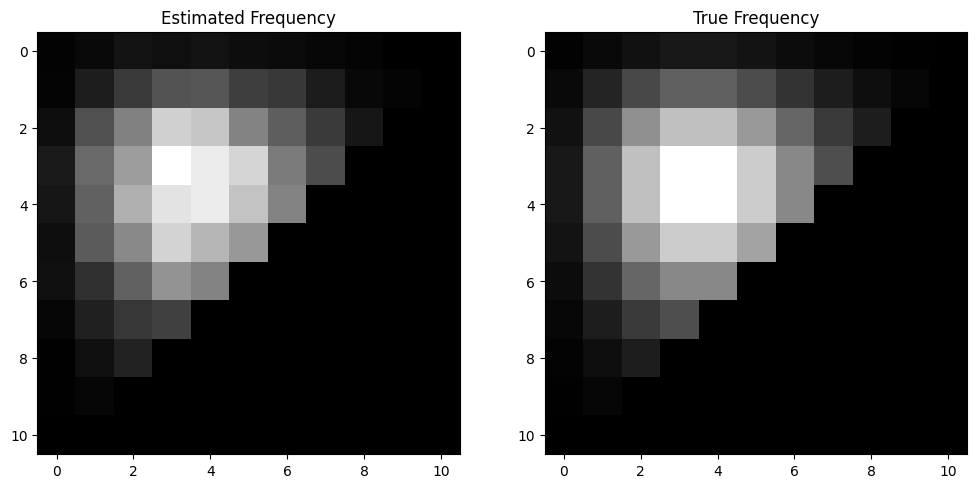

In [ ]:
vals = metropolis_hastings2D_coord()
show_comparison2D(vals, poisson2D()*vals.shape[0])

We perform the usual set of tests to check if the samples indeed come from the desired distribution.

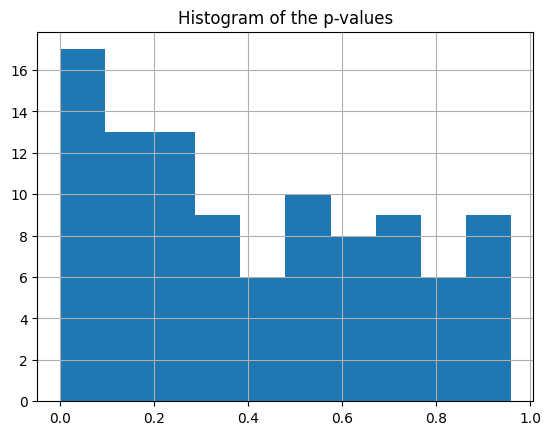

In [ ]:
true_f = poisson2D()
mask = true_f !=0

p_values = []
for i in range(100):
    vals = metropolis_hastings2D_coord()[::4] # the values are dependent with each other
    counts = np.empty((11,11))
    for i in range(11):
        for j in range(11):
            counts[i,j] = np.sum(np.logical_and(vals[:,0]==i, vals[:,1]==j))
    true_f = poisson2D()*vals.shape[0]
    p_values.append(stats.chisquare(counts[mask].flatten(), true_f[mask].flatten())[1])

plt.hist(p_values)
plt.title('Histogram of the p-values')
plt.grid()
plt.show()

<h3> (2c) Gibbs sampling coordinate wise </h3>

The following function outputs a vector of probabilities. This probability masses represents the conditional probability of i given j when sampling new states in the Gibbs algorithm. Since the distribution is symmetric the probability distribution of j given i is the same of the previous one, so we do not distinguish between the two cases.

In [ ]:
def condProb(z):
    probs = poisson2D()
    s = np.sum(probs[z,:])
    p = np.zeros(11)
    for k in range(len(p)):
        p[k] = probs[z,k]/s
    return p

The algorithm with Gibbs sampling is implemented as follows. When sampling the new states, first we move in one direction fixing the other (using the conditional probability defined above) and then we move in the other direction, again using the conditional probability.

In [ ]:
def metropolis_hastings2D_gibbs(init = [0,0], size = 10000):
    A1 = 4
    A2 = 4
    m = 10

    res = np.empty((size,2))
    n = 1
    res[0,:] = init
    i = init[0]
    j = init[1]
    while n < size:
        p = condProb(j)
        new_i = np.random.choice(np.arange(11), p = p)
        p = condProb(int(new_i))
        new_j = np.random.choice(np.arange(11), p = p)

        res[n, :] = [new_i, new_j] #saving the new state
        i = new_i
        j = new_j

        n += 1
    return res

We visually inspect the results

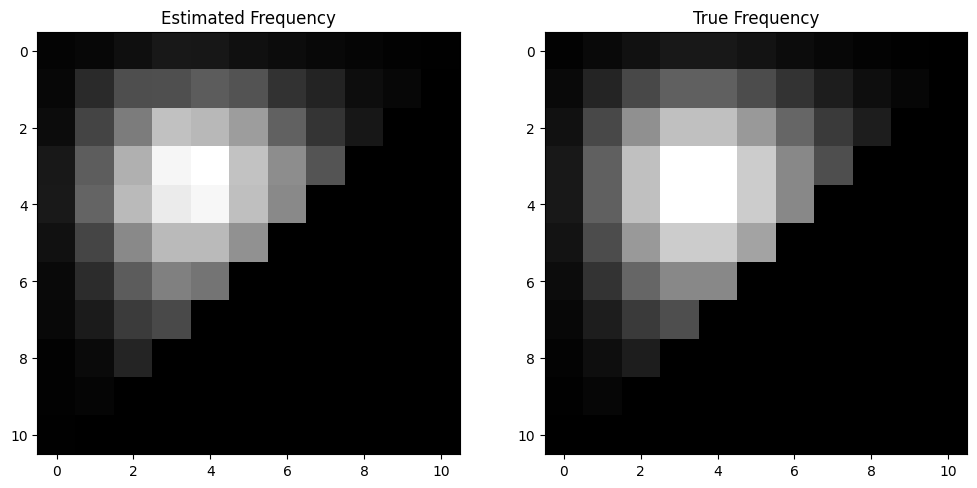

In [ ]:
vals = metropolis_hastings2D_gibbs()
show_comparison2D(vals, poisson2D()*vals.shape[0])

We perform the usual set of χ2 tests to see if the samples come indeed from the desired distribution. If so, the p-values should be uniformly dsitributed between 0 and 1, as seen in the plot below.

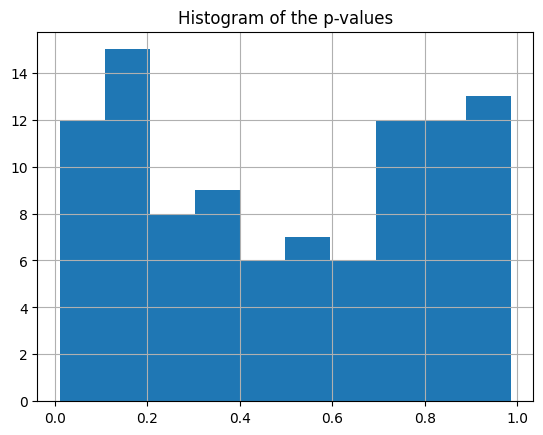

In [ ]:
true_f = poisson2D()
mask = true_f!=0
p_values = []
for i in range(100):
    vals = metropolis_hastings2D_gibbs()[::4] # the values are dependent with each other
    counts = np.empty((11,11))
    for i in range(11):
        for j in range(11):
            counts[i,j] = np.sum(np.logical_and(vals[:,0]==i, vals[:,1]==j))
    true_f = poisson2D()*vals.shape[0]
    p_values.append(stats.chisquare(counts[mask].flatten(), true_f[mask].flatten())[1])

plt.hist(p_values)
plt.title('Histogram of the p-values')
plt.grid()
plt.show()

<h3> (3) Bayesian problem  </h3>

Point a

In [16]:
sampled = np.random.multivariate_normal([0,0], cov = [[1,1/2],[1/2,1]])
params = np.exp(sampled)

Point b

In [17]:
xlist = stats.norm.rvs(params[0], np.sqrt(params[1]), size = 10)
xlist

array([0.74532495, 1.93467185, 2.26605679, 0.87684496, 3.89535583,
       0.99679379, 1.06497549, 2.86723738, 0.75727116, 0.91560104])

Point c

In [18]:
def g(Xi, theta, psi):
    A = 1/(np.sqrt(6*np.pi*psi)*np.pi*psi*theta)**Xi.shape[0]
    return np.exp(np.sum(-(Xi - theta)**2/psi - (np.log(theta)**2 - np.log(theta)*np.log(psi)+np.log(psi)**2)*2/3))/A


Point d

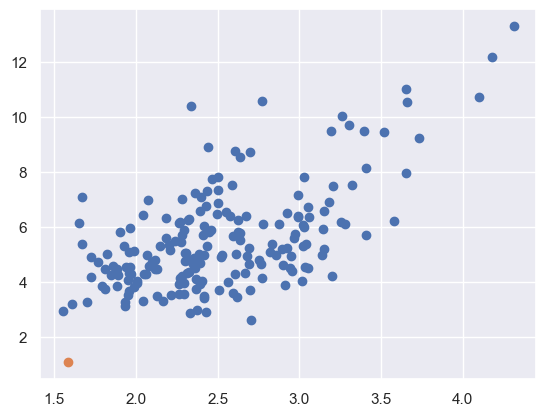

In [19]:
theta_psi_list = []
x_log = np.random.multivariate_normal([0,0], cov = [[1,1/2],[1/2,1]])
x = np.exp(x_log)
for i in range(10000):
    y_log = np.random.multivariate_normal([0,0], cov = [[1,1/2],[1/2,1]])
    y = np.exp(y_log)

    gx = g(xlist, x[0], x[1])
    gy = g(xlist, y[0], y[1])

    if gy >= gx:
            theta_psi_list.append(y)
            x = y
    else:
        p = np.random.rand(1)
        if (p < gy/gx):
            theta_psi_list.append(y)
            x = y

theta_psi_list = np.array(theta_psi_list)

plt.scatter(theta_psi_list[:,0], theta_psi_list[:,1])
plt.scatter(params[0], params[1])
plt.show()

Point e

In [21]:
import warnings

xlist = stats.norm.rvs(params[0], np.sqrt(params[1]), size = 100)

warnings.filterwarnings('ignore')

theta_psi_list = []
x_log = np.random.multivariate_normal([0,0], cov = [[1,1/2],[1/2,1]])
x = np.exp(x_log)
for i in range(100):
    y_log = np.random.multivariate_normal([0,0], cov = [[1,1/2],[1/2,1]])
    y = np.exp(y_log)

    gx = g(xlist, x[0], x[1])
    gy = g(xlist, y[0], y[1])

    if gy >= gx:
            theta_psi_list.append(y)
            x = y
    else:
        p = np.random.rand(1)
        if (p < gy/gx):
            theta_psi_list.append(y)
            x = y

theta_psi_list, params

([array([0.96966172, 0.83244953]),
  array([0.84245266, 1.78607095]),
  array([3.78881498, 3.44020119]),
  array([1.46005663, 4.57137182]),
  array([ 1.91886593, 10.27579716]),
  array([3.52517138, 5.25715933])],
 array([1.58633205, 1.07536169]))

# Exercise 7: Simulated Annealing

<h3> (1) Travelling Salesman with Random Coordinates

The travelling salesman problem concerns finding the optimal path for some salesman, given a number of locations. These locations has a distance (or rather a cost) between them. Thus, functions for generating locations and costs are needed. Additionally, to implement simulated annealing some form of route-permutation is needed for each simulation. In this case, two locations (which are not the start/end location) are randomly switched (note that start/end can be included depending on the assumptions) - this can be seen as a "neighbor-route. Finally, a cooling function is required to to make the algorithm converge. This could be many decreasing functions - but the performance could depend on the choice. 1/sqrt(1-k) seems to work well.

In [23]:
#generates random coordinates for an enumerated list of locations.
def random_coordinates(X):
    C= np.random.randint(0,100+1,[len(X)-1,2]).tolist()
    C.insert(X[-1],C[X[-1]])
    return np.array(C)

#Computes the cost of a route (total euclidean distance)
def CostEuclid(route,coord):
    dist = [ np.sqrt( (coord[route[N+1] ,0] - coord[route[N] ,0])**2 + (coord[route[N+1] ,1] - coord[route[N] ,1])**2)  for N in range(len(route)-1)]
    return np.sum(dist)


def random_neighbor(state):
    a = np.array(state)
    r1,r2 = np.random.randint(1, len(state)-2, 2)
    a[r1],a[r2] = a[r2],a[r1]
    return a

#Cooling scheme
def cool(k):
    return 1/np.sqrt(1+k)
    #return 1/ np.log(k+1)
    #return - np.log(k+1)


The simulation can now be implemented. The initial route and all route costs are tracked.


In [37]:

#initial random solution with 20 stations
X = np.array(range(20))
np.random.shuffle(X) #randomize starting route

X = np.concatenate([X,[X[0]]])
init_X = X

#making coordinates and costs
XC = random_coordinates(X)
U = CostEuclid(X,XC)

n = 100000#number of simulations

cost_tracker = np.zeros(n)


kc = 0
ks = 0.0001
for k in range(n):
    T = cool(kc)
    X_candidate = random_neighbor(X)
    
    
    U_candidate = CostEuclid(X_candidate,XC)
    
    if U_candidate < U:
        X = X_candidate
        U = U_candidate
    elif np.exp(-(U_candidate-U)/T ) > np.random.random():
        #print(np.exp(-(U_candidate-U)/T ))
        X = X_candidate
        U = U_candidate
    cost_tracker[k] = U
    kc = kc+ks#+0.005

Plots of cost progression, initial route and final route are shown below.

Optimal Route:  [11  3 15  4  6 19 13 14  2  1 17  0  8  5  9 10  7 16 18 12 11]


Text(0.5, 1.0, 'Final Route')

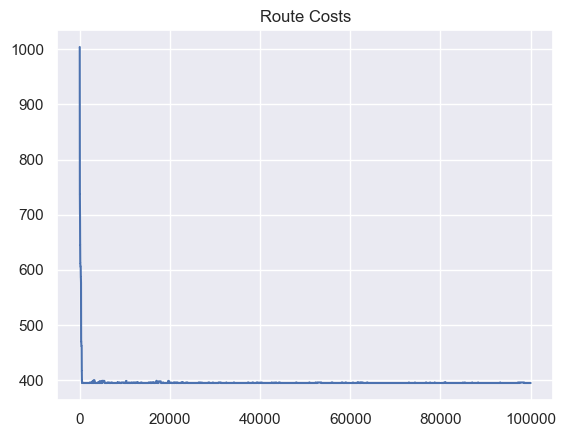

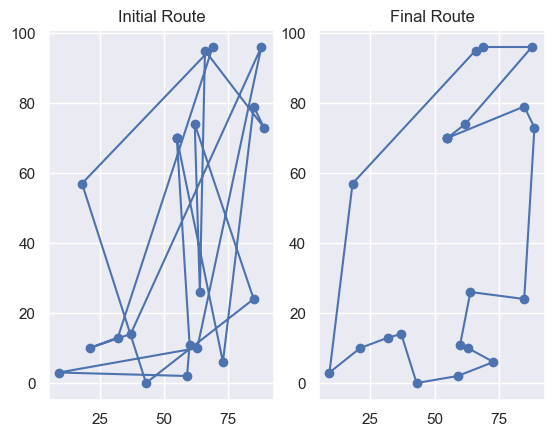

In [38]:
#optimal route
print("Optimal Route: ", X)

#plots
plt.figure()
plt.plot(cost_tracker)
plt.title("Route Costs")

plt.figure()
plt.subplot(1,2,1)
plt.scatter(XC[init_X][:,0],XC[init_X][:,1])
plt.plot(XC[init_X][:,0],XC[init_X][:,1])
plt.title("Initial Route")

plt.subplot(1,2,2)
plt.scatter(XC[X][:,0],XC[X][:,1])
plt.plot(XC[X][:,0],XC[X][:,1])
plt.title("Final Route")


It can be observed that the route goes from completely random to an optimal (or near optimal) solution. With more simulations (n) the chance of finding the true optimal solution increases. From the route costs it can be seen that the algorithm converges fast, but sometimes some fluctuations can be seen, which entails that a worse route is accepted ( with the intention of escaping local minima. The probability of these fluctuations changes depending on the cooling constant (kc).


<h3> (2) Travelling Salesman with Costs

The code can easily be extended to use the given cost matrix instead of the euclidean distance.

Optimal route:  [12  3  5 11  4  7 15  9  8 13  0  6 17 16 10 19  2  1 14 18 12]


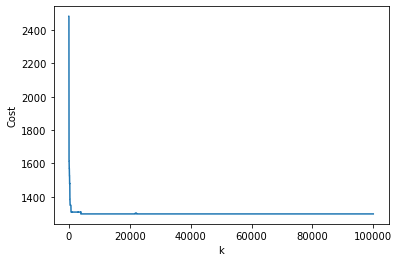

In [ ]:
#importing Travelling Salesman Matrix
#df = pd.read_csv(os.path.join(os.getcwd(), '../filip', 'cost.csv'), header = None)
df = pd.read_csv(os.path.join(os.getcwd(), 'cost.csv'), header = None)
TSM = df.to_numpy()

def cost(route):
    c = 0
    for k in range(len(route)-1):
        c += TSM[route[k],route[k+1]]
    return c


#simulation
#initial random solution
init = np.array(range(len(TSM)))
random.shuffle(init) #randomize starting route

init = np.concatenate([init,[init[0]]])
#print(init)
init_cost = cost(init)


n = 100000#number of simulations
X = init
U = cost(X)

cost_tracker = np.zeros(n)


kc = 0
ks = 0.0001

for k in range(n):
    T = cool(kc)
    X_candidate = random_neighbor(X)
    U_candidate = cost(X_candidate)
    
    if U_candidate < U:
        X = X_candidate
        U = U_candidate
    elif np.exp(-(U_candidate-U)/T ) > random.random():
        #print(np.exp(-(U_candidate-U)/T ))
        X = X_candidate
        U = U_candidate
    cost_tracker[k] = U
    kc = kc + ks #+0.005

#plot
plt.figure()
plt.plot(range(n),cost_tracker,marker=' ')
plt.xlabel('k')
plt.ylabel('Cost')


#chosen route: 
print("Optimal route: ", X)

Again, the costs can be seen to converge towards an optimal solution. In conclusion, an optimisation problem can relatively easily be solved to (near) optimality using simulated annealing.

# Exercise 8: Bootstrap methods

<h3> (1)

The Bootstrap approach can be used to estimate p. This is done by randomly sampling from a list (can be considered the target distribution), for a number of simulations (r). For each simulation a mean can be estimated. Using these estimations, it can be examined how often the conditions are fullfulled.

The implementation is made below.

In [ ]:
#%% Question 1
def bootstrap(X):
    n = len(X)
    return np.random.choice(X,n),n

r = 100
X = np.array([56, 101, 78, 67, 93, 87, 64, 72, 80, 69])
a,b=-5,5

count=0
for i in range(r):
    sim,n = bootstrap(X)
    mu = np.mean(sim)
    if np.logical_and(a < sum(X/n)-mu,sum(X/n)-mu < b):
        count+=1

P = count/r

print(P)

0.75


It can be seen that the condition is true around 75% of the time

<h3> (2)

Using the data shown in the exercise the variance of the estimated variance can be computed.

In [ ]:
#%% Question 2
X = [5,4,9,6,21,17,11,20,7,10,21,15,13,16,8]


r = 1000
var = np.zeros(r)
for i in range(r):
    sim,n = bootstrap(X)
    var[i] = np.var(sim,ddof=1)

print("var(s^2): ",np.var(var,ddof=1))

var(s^2):  57.03025328375995


<h3> (3)

For the exercise we will define a function which outputs the sample median and variance.

In [ ]:

def bootstrapEstimateMed(X,r):
    sample_med = np.median(X)
    n = len(X)
    
    bts = np.random.choice(X,[n,r])
    b_med = np.median(bts,axis=0)
    b_var = np.var(b_med,ddof=1)
    
    return sample_med, b_var
    

N = 200
X = stats.pareto.rvs(1.05,size=N)
r = 100



<h4> a) Mean and Median

The true mean and median are calculated.

In [ ]:
print("mean: ",np.mean(X))
print("median: ",np.median(X))

mean:  4.680944968041803
median:  1.9007765099739646


<h4> b) Variance of sample mean

We want to examine the variance of the Bootstrap estimates of the mean. Thus, a function computing the sample mean and variance of the sample mean is created and used.

In [ ]:
#%% B
def bootstrapEstimateMean(X,r):
    sample_mean = np.mean(X)
    n = len(X)
    
    bts = np.random.choice(X,[n,r])
    b_mean = np.mean(bts,axis=0)
    b_var = np.var(b_mean,ddof=1)
    return sample_mean, b_var

print(bootstrapEstimateMean(X,r))

(4.680944968041803, 0.8551287983736425)


<h4> c) Variance of sample median

The same is done for the median. We already created this function in the beginning of (3).

In [ ]:
print(bootstrapEstimateMed(X, r))

(1.9007765099739646, 0.015967024662851992)


<h4> d) Precision of median and mean estimations

The estimations of the sample mean and median has different precisions. They are compared below.

In [ ]:
N = 10000
X = stats.pareto.rvs(1.05,size=N)
r = 100

print("mean: ", bootstrapEstimateMean(X,r))

print("median: ",bootstrapEstimateMed(X,r))

#it is easier to estimate the median than the mean<

mean:  (7.326363113950223, 1.9920850010808981)
median:  (1.9602197728541069, 0.00027839453549673106)


As it can be seen of the low precision and high variance, it is very hard to estimate the true mean using empirical methods for the pareto with k=1.05. This is because the pareto has a considerable probability of sampling large numbers. These are somewhat rare, meaning that the sampling wont properly work except if the sample size is incredibly large.


In contrast the median is much more precise, with a very low variance.  The median is easier because it is not dependant on sampling the large values of the pareto distribution.